## Section 1. Introduction ##

In this notebook, the dataset to be processed is the Labor Force Survey conducted April 2016 and retrieved through Philippine Statistics Authority database. 



In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.style.use('ggplot')

# autoreload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# import os
# import sys
# import random
# import pickle
# import h5py

# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from torch.optim.lr_scheduler import StepLR

<h1>Importing LFS PUF April 2016.CSV</h1>

In [2]:
try:
    lfs_data = pd.read_csv("src/data/LFS PUF April 2016.CSV")
except FileNotFoundError:
    print("Error: CSV file not found. Please make sure the file exists in the correct directory or provide the correct path.")
    exit()

<h1>Data Information, Pre-Processing, and Cleaning</h1>

Let's get an overview of our dataset.

In [3]:
lfs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180862 entries, 0 to 180861
Data columns (total 50 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   PUFREG           180862 non-null  int64  
 1   PUFPRV           180862 non-null  int64  
 2   PUFPRRCD         180862 non-null  int64  
 3   PUFHHNUM         180862 non-null  int64  
 4   PUFURB2K10       180862 non-null  int64  
 5   PUFPWGTFIN       180862 non-null  float64
 6   PUFSVYMO         180862 non-null  int64  
 7   PUFSVYYR         180862 non-null  int64  
 8   PUFPSU           180862 non-null  int64  
 9   PUFRPL           180862 non-null  int64  
 10  PUFHHSIZE        180862 non-null  int64  
 11  PUFC01_LNO       180862 non-null  int64  
 12  PUFC03_REL       180862 non-null  int64  
 13  PUFC04_SEX       180862 non-null  int64  
 14  PUFC05_AGE       180862 non-null  int64  
 15  PUFC06_MSTAT     180862 non-null  object 
 16  PUFC07_GRADE     180862 non-null  obje

---
Of interest to us, there are:
<ul><li>1 contains float values, </li>
<li>14 contain integer values, and </li>
<li><b>35 are object values</b>.</li></ul>


---
Let's check for duplicates:

In [4]:
lfs_data.duplicated().sum()

np.int64(0)

No duplicates here, and therefore no cleaning need follow in this regard.

The dataset seems to contain null values in the form of whitespaces. Let's count those:

In [5]:
has_null = lfs_data.apply(lambda col: col.str.isspace().sum() if col.dtype == 'object' else 0)

print("Number Empty Cells:")
print(has_null[has_null > 0])

Number Empty Cells:
PUFC06_MSTAT        18339
PUFC07_GRADE        18339
PUFC08_CURSCH      107137
PUFC09_GRADTECH     57782
PUFC10_CONWR        57782
PUFC11_WORK         21894
PUFC12_JOB          93306
PUFC14_PROCC       108360
PUFC16_PKB         108360
PUFC17_NATEM       109507
PUFC18_PNWHRS      109507
PUFC19_PHOURS      109507
PUFC20_PWMORE      109507
PUFC21_PLADDW      109507
PUFC22_PFWRK       109507
PUFC23_PCLASS      109507
PUFC24_PBASIS      138947
PUFC25_PBASIC      144274
PUFC26_OJOB        109507
PUFC27_NJOBS       174924
PUFC28_THOURS      109507
PUFC29_WWM48H      163629
PUFC30_LOOKW       132692
PUFC31_FLWRK       178569
PUFC32_JOBSM       178569
PUFC33_WEEKS       178569
PUFC34_WYNOT       134985
PUFC35_LTLOOKW     179269
PUFC36_AVAIL       174893
PUFC37_WILLING     174893
PUFC38_PREVJOB     132692
PUFC40_POCC        152982
PUFC41_WQTR         81627
PUFC43_QKB         107825
PUFNEWEMPSTAT       61337
dtype: int64


---
Now, we do not want to immediately convert all null values to an arbitrary value like __NaN__ or __-1__.

Instead, we want to __clean the data__ according to __how each column/variable is manipulated__. 

And so, as all of the columns have numerical values (__integer64__ or __float64__), we want to impute the data into numerical equivalents as well; if they even need any sort of imputation.

we shall preprocess the columns that we will be using in our models that do not have any whitespace null values.

---
### PUFC06_MSTAT
_Marital status of the person since last birthday_

In [6]:
print("Data Type of PUFC06_MSTAT: ", lfs_data['PUFC06_MSTAT'].dtype)
print("Values Used in PUFC06_MSTAT: ", sorted(lfs_data['PUFC06_MSTAT'].unique()))

Data Type of PUFC06_MSTAT:  object
Values Used in PUFC06_MSTAT:  [' ', '1', '2', '3', '4', '5', '6']


We can see that the column PUFC06_MSTAT is of data type ___Object___, even if it supposedly contains numeric int64 numbers. 

We can also observe that this is the first column that contains empty/null/whitespace values in its entries.

Because of this, we first have to preprocess its contents to become purely integers before we can use them in our modelling.


First and foremost, we handle the whitespace and turn all instances to __-1__.

Then, we convert all strings of these numbers to their __equivalent int64__ values.

We will also make sure that all entries within the columns are of data type ___int64___.

In [7]:
lfs_data.loc[lfs_data['PUFC06_MSTAT'] == " ", 'PUFC06_MSTAT'] = -1
lfs_data['PUFC06_MSTAT'] = lfs_data['PUFC06_MSTAT'].astype('int64')

Upon further analysis of the column and its equivalent question, we can figure out that we can actually allocate the null/whitespace/-1 values to the integer __6__ because this is the category for unknown marital status.

In [8]:
lfs_data.loc[lfs_data['PUFC06_MSTAT'] == -1, 'PUFC06_MSTAT'] = 6

Let us double check our progress.

In [9]:
print("Data Type of PUFC06_MSTAT: ", lfs_data['PUFC06_MSTAT'].dtype)
print("Values Used in PUFC06_MSTAT: ", np.sort(lfs_data['PUFC06_MSTAT'].unique().tolist()))

Data Type of PUFC06_MSTAT:  int64
Values Used in PUFC06_MSTAT:  [1 2 3 4 5 6]


---
### PUFC07_GRADE

_Highest grade completed of the person_

In [10]:
print("Data Type of PUFC07_GRADE: ", lfs_data['PUFC07_GRADE'].dtype)
print("Values Used in PUFC07_GRADE: \n", np.sort(lfs_data['PUFC07_GRADE'].unique().tolist()))

Data Type of PUFC07_GRADE:  object
Values Used in PUFC07_GRADE: 
 ['   ' '000' '010' '210' '220' '230' '240' '250' '260' '280' '310' '320'
 '330' '340' '350' '410' '420' '501' '514' '521' '522' '531' '532' '534'
 '542' '544' '548' '552' '554' '558' '562' '564' '572' '576' '581' '584'
 '585' '586' '589' '601' '614' '621' '622' '631' '632' '634' '638' '642'
 '644' '646' '648' '652' '654' '658' '662' '664' '672' '676' '681' '684'
 '685' '686' '689' '810' '820' '830' '840' '900']


Upon observation, we can see that there is a whitespace value. We shall convert that to -1 for the sake of preserving a homogenous data type. 

Seeing also how the values of this column are numeric integers but in String form, we can call the function .astype() and convert them accordingly.

In [11]:
lfs_data.loc[lfs_data['PUFC07_GRADE'] == "   ", 'PUFC07_GRADE'] = -1
lfs_data['PUFC07_GRADE'] = lfs_data['PUFC07_GRADE'].astype('int64')

We cannot impute this __-1__ value any further and can only interpret such as having no grade completed.

In [12]:
print("Data Type of PUFC07_GRADE: ", lfs_data['PUFC07_GRADE'].dtype)
print("Values Used in PUFC07_GRADE: \n", np.sort(lfs_data['PUFC07_GRADE'].unique().tolist()))

Data Type of PUFC07_GRADE:  int64
Values Used in PUFC07_GRADE: 
 [ -1   0  10 210 220 230 240 250 260 280 310 320 330 340 350 410 420 501
 514 521 522 531 532 534 542 544 548 552 554 558 562 564 572 576 581 584
 585 586 589 601 614 621 622 631 632 634 638 642 644 646 648 652 654 658
 662 664 672 676 681 684 685 686 689 810 820 830 840 900]


As we now have a homogenous int64 column, we can analyze the values on a deeper level.

Upon inspection of the actual Labor Force Survey _Questionnaire_, we can see that some codes that are present in the displayed values were not explicitly declared in the manual.

In [13]:
valid_codes = [ # These are the codes that were explicitly defined in the manual
    0,                                                  # No Grade
    10,                                                 # Preschool
    210, 220, 230, 240, 250, 260, 280,                  # Elementary (Grade 1 to Elementary Graduate)
    310, 320, 330, 340, 350,                            # High School (First Year to High School Graduate)
    410, 420,                                           # Post Secondary; If Graduate Specify
    810, 820, 830, 840,                                 # College; If Graduate Specify
    900                                                 # Post Baccalaureate
    # "   "                                             # White Space Empty/Missing Values
]

We have decided to label all explicitly defined codes as __valid codes__.

This entails that the PSA must have assigned certain numbers in order to represent the Post Secondary and College courses of those who have graduated. This range is between 421 to 809.

When compared to the actual values within the dataset, we can now infer that there exists unspecified codes that exist in the dataset.

We decided to call these __invalid codes__.

In [14]:
invalid_values = np.sort(lfs_data[~(lfs_data['PUFC07_GRADE'].isin(valid_codes))]['PUFC07_GRADE'].unique())

These invalid codes include __-1__ (the arbitrary code for __Missing Values__) and all other undefined non-explicit codes that we hypothesize to represent __Post Secondary__ and __College__ courses.

In [15]:
missing_values = [-1]

graduate_specified_courses = [int(x) for x in [value for value in invalid_values if value not in missing_values]]

For simplicity's sake, we allocated a new arbitrary code, __code 700__, to contain all graduate specified courses.

In [16]:
lfs_data["PUFC07_GRADE"] = lfs_data["PUFC07_GRADE"].apply(lambda x: 700 if x in graduate_specified_courses else x)

For a quick summary of the Data Preprocessing above:

In [17]:
print("\nPUFC07_GRADE Data Type: ", lfs_data['PUFC07_GRADE'].dtype)
print("\nUnique Codes in Column: ", np.sort(lfs_data['PUFC07_GRADE'].unique().tolist()))
print("\nValid Codes: ", valid_codes)
print("\nInvalid Codes: ", invalid_values)
print("\nAssigned Missing Code: ", missing_values)
print("\nCodes for Hypothesized Graduate Specified Courses: ", graduate_specified_courses)
print("\nArbitrary Code for Graduate Specified Courses: ", 700)


PUFC07_GRADE Data Type:  int64

Unique Codes in Column:  [ -1   0  10 210 220 230 240 250 260 280 310 320 330 340 350 410 420 700
 810 820 830 840 900]

Valid Codes:  [0, 10, 210, 220, 230, 240, 250, 260, 280, 310, 320, 330, 340, 350, 410, 420, 810, 820, 830, 840, 900]

Invalid Codes:  [ -1 501 514 521 522 531 532 534 542 544 548 552 554 558 562 564 572 576
 581 584 585 586 589 601 614 621 622 631 632 634 638 642 644 646 648 652
 654 658 662 664 672 676 681 684 685 686 689]

Assigned Missing Code:  [-1]

Codes for Hypothesized Graduate Specified Courses:  [501, 514, 521, 522, 531, 532, 534, 542, 544, 548, 552, 554, 558, 562, 564, 572, 576, 581, 584, 585, 586, 589, 601, 614, 621, 622, 631, 632, 634, 638, 642, 644, 646, 648, 652, 654, 658, 662, 664, 672, 676, 681, 684, 685, 686, 689]

Arbitrary Code for Graduate Specified Courses:  700


For further clarification, the range of allowed values for this column is -1 to 900.

* -1 is allocated as the unknown highest accomplished grade level

* 700 is allocated for the specified courses (hypothesized inference according to manual)

* and the rest are left as is

### PUFC08_CURSCH
_Is the person currently attending school?_

Similar to PUFC04_SEX, we want to convert the column's data type from Object --> to Int64 --> to Bool, in order to properly represent the status of the entire population.

In [18]:
print("Data Type of PUFC08_CURSCH: ", lfs_data['PUFC08_CURSCH'].dtype)
print("Values Used in PUFC08_CURSCH: ", sorted(lfs_data['PUFC08_CURSCH'].unique()))

Data Type of PUFC08_CURSCH:  object
Values Used in PUFC08_CURSCH:  [' ', '1', '2']


The column also contains much whitespace/null values, hence it is necessary for us to understand why.

Upon further inspection, we can see that the column only requires those between ages 5 to 24 to answer whether or not they are still studying at an academic institution. 

From this, we can infer that the reason there is around a 60% amount of whitespace in this column is because the remaining 40% are ages beyond this range. 

Furthermore, because the survey itself does not measure the status of those __beyond__ that __5 to 24 range__, we can assume their answer to be: __No, they are NOT currently attending school.__

In [19]:
lfs_data.loc[lfs_data['PUFC08_CURSCH'] == " ", 'PUFC08_CURSCH'] = 2
# lfs_data['PUFC08_CURSCH'] = lfs_data['PUFC08_CURSCH'].map({1: True, 2: False})        # ONLY RUN THESE 2 LINES OF CODE ONCE
# lfs_data['PUFC08_CURSCH'] = lfs_data['PUFC08_CURSCH'].astype('bool')                  # IT MESSES UP THE BOOLEAN VALUES because of the mapping of 1 to TRUE
#                                                                                         # it turns all values to true, and all false values are lost
lfs_data['PUFC08_CURSCH'] = lfs_data['PUFC08_CURSCH'].astype('int64')

Let us check our conversion:

In [20]:
print("Data Type of PUFC08_CURSCH: ", lfs_data['PUFC08_CURSCH'].dtype)
print("Values Used in PUFC08_CURSCH: \n", np.sort(lfs_data['PUFC08_CURSCH'].unique().tolist()))

Data Type of PUFC08_CURSCH:  int64
Values Used in PUFC08_CURSCH: 
 [1 2]


### PUFC11_WORK

_Did the person do any work for at least one house during the past week?_

In [21]:
lfs_data.loc[lfs_data['PUFC11_WORK'] == " ", 'PUFC11_WORK'] = 2
lfs_data.loc[lfs_data['PUFC11_WORK'] == "1", 'PUFC11_WORK'] = 1
lfs_data.loc[lfs_data['PUFC11_WORK'] == "2", 'PUFC11_WORK'] = 2
lfs_data['PUFC11_WORK'] = lfs_data['PUFC11_WORK'].astype('int64')
# lfs_data['PUFC11_WORK'] = lfs_data['PUFC11_WORK'].map({1: True, 2: False})        # ONLY RUN THESE 2 LINES OF CODE ONCE
# lfs_data['PUFC11_WORK'] = lfs_data['PUFC11_WORK'].astype('bool')                  # IT MESSES UP THE BOOLEAN VALUES because of the mapping of 1 to TRUE
#                                                                                         # it turns all values to true, and all false values are lost

### PUFC30_LOOKW

_Did the person look for work or try to establish a business in the past week?_

question 28 seeks to identify people who overwork themselves
if num28 == <= 48, skip 30
if the person works more than 10 hours per day 5 days a week, answer 30
else keep answering

this entails that answering question 30 will figure out why people overwork themselves and still find more work
this means, if num30 is skipped, then whitespaced
if whitespaced, num28 answer is <=48
worker worked 48 hours or less 

the data used in PUFC30_LOOKW are from people who have working hours greater than 48 hours this week

PUFC11_WORK Did the person do any work for at least one hour during the past week?
1 Yes (if yes, leave PUFC12_JOB blank)
2 No

PUFC30_LOOKW Did the person look for work or try to establish a business in the past week?
1 Yes
2 No (Skip to 34)

The statistic we want to show for comparing PUFC11_WORK and PUFC30_LOOKW are the number of people who are overworked and STILL looking for more work (or not).
find stats/relationship on wage and overwork


PUFC30_LOOKW if whitespace/skipped, then that means the person has working hours <=48, WHICH MEANS that they DO have work

In [22]:
# 1 Convert whitespace to -1, string 1 to int64 1, string 2 to int64 2
lfs_data.loc[lfs_data['PUFC30_LOOKW'] == " ", 'PUFC30_LOOKW'] = -1
lfs_data.loc[lfs_data['PUFC30_LOOKW'] == "1", 'PUFC30_LOOKW'] = 1
lfs_data.loc[lfs_data['PUFC30_LOOKW'] == "2", 'PUFC30_LOOKW'] = 2
lfs_data['PUFC30_LOOKW'] = lfs_data['PUFC30_LOOKW'].astype('int64')

# 2 Copy the PUFC30_LOOKW column to a new column
lfs_data['PUFC30_LOOKW_version2'] = lfs_data['PUFC30_LOOKW'].copy()
lfs_data.loc[lfs_data['PUFC30_LOOKW_version2'] == -1, 'PUFC30_LOOKW_version2'] = 2

# 2.1 Convert int64 1 to True, int64 2 to False
# lfs_data.loc[lfs_data['PUFC30_LOOKW_version2'] == 1, 'PUFC30_LOOKW_version2'] = True
# lfs_data.loc[lfs_data['PUFC30_LOOKW_version2'] == 2, 'PUFC30_LOOKW_version2'] = False
# lfs_data['PUFC30_LOOKW_version2'] = lfs_data['PUFC30_LOOKW_version2'].astype('bool')

In [23]:
overworked_people = (lfs_data['PUFC30_LOOKW'] == -1).sum()
not_overworked_people = (lfs_data['PUFC30_LOOKW'] == 1).sum() + (lfs_data['PUFC30_LOOKW'] == 2).sum()
total_population = overworked_people + not_overworked_people

print(f"People who are NOT overworked: ", overworked_people)
print(f"Percentage: ", 100 * overworked_people / total_population, "%")
print(f"\nPeople who ARE overworked: ", not_overworked_people)
print(f"Percentage: ", 100 * not_overworked_people / total_population, "%")

People who are NOT overworked:  132692
Percentage:  73.36643407680994 %

People who ARE overworked:  48170
Percentage:  26.633565923190055 %


### PUFC31_FLWRK

_Was it the person's first time looking for work or trying to establish a business?_

In [24]:

# PUFC31_FLWRK
# 1 Convert whitespace to -1, string 1 to int64 1, string 2 to int64 2
lfs_data.loc[lfs_data['PUFC31_FLWRK'] == " ", 'PUFC31_FLWRK'] = -1
lfs_data.loc[lfs_data['PUFC31_FLWRK'] == "1", 'PUFC31_FLWRK'] = 1
lfs_data.loc[lfs_data['PUFC31_FLWRK'] == "2", 'PUFC31_FLWRK'] = 2
lfs_data['PUFC31_FLWRK'] = lfs_data['PUFC31_FLWRK'].astype('int64')

# 2 Copy the PUFC30_LOOKW column to a new column
lfs_data['PUFC31_FLWRK_version2'] = lfs_data['PUFC31_FLWRK'].copy()
lfs_data.loc[lfs_data['PUFC31_FLWRK_version2'] == -1, 'PUFC31_FLWRK_version2'] = 2

# 2.1 Convert int64 1 to True, int64 2 to False
# lfs_data.loc[lfs_data['PUFC31_FLWRK_version2'] == 1, 'PUFC31_FLWRK_version2'] = True
# lfs_data.loc[lfs_data['PUFC31_FLWRK_version2'] == 2, 'PUFC31_FLWRK_version2'] = False
# lfs_data['PUFC31_FLWRK_version2'] = lfs_data['PUFC31_FLWRK_version2'].astype('bool')

# 2.2 Check if column is bool datatype
print(lfs_data['PUFC31_FLWRK_version2'].dtype)
print(lfs_data['PUFC31_FLWRK_version2'].unique())


int64
[2 1]


### PUFC34_WYNOT

_Reason for not looking for work Why did the person not look for work?_

In [25]:
# # PUFC34_WYNOT
# 1 Convert whitespace to -1, string 1 to int64 1, string 2 to int64 2
lfs_data.loc[lfs_data['PUFC34_WYNOT'] == " ", 'PUFC34_WYNOT'] = -1
lfs_data.loc[lfs_data['PUFC34_WYNOT'] == "1", 'PUFC34_WYNOT'] = 1
lfs_data.loc[lfs_data['PUFC34_WYNOT'] == "2", 'PUFC34_WYNOT'] = 2
lfs_data.loc[lfs_data['PUFC34_WYNOT'] == "3", 'PUFC34_WYNOT'] = 3
lfs_data.loc[lfs_data['PUFC34_WYNOT'] == "4", 'PUFC34_WYNOT'] = 4
lfs_data.loc[lfs_data['PUFC34_WYNOT'] == "5", 'PUFC34_WYNOT'] = 5
lfs_data.loc[lfs_data['PUFC34_WYNOT'] == "6", 'PUFC34_WYNOT'] = 6
lfs_data.loc[lfs_data['PUFC34_WYNOT'] == "7", 'PUFC34_WYNOT'] = 7
lfs_data.loc[lfs_data['PUFC34_WYNOT'] == "8", 'PUFC34_WYNOT'] = 8
lfs_data.loc[lfs_data['PUFC34_WYNOT'] == "9", 'PUFC34_WYNOT'] = 9
lfs_data['PUFC34_WYNOT'] = lfs_data['PUFC34_WYNOT'].astype('int64')

# 2 Copy the PUFC34_WYNOT column to two new columns
# lfs_data['PUFC34_WYNOT_version2'] = lfs_data['PUFC34_WYNOT'].copy()
# lfs_data['PUFC34_WYNOT_version2'] = lfs_data['PUFC34_WYNOT_version2']

lfs_data['PUFC34_WYNOT_version3'] = lfs_data['PUFC34_WYNOT'].copy()
lfs_data.loc[lfs_data['PUFC34_WYNOT_version3'] == -1, 'PUFC34_WYNOT_version3'] = 9

### PUFC38_PREVJOB

_Has the person worked at any time before?_

In [26]:
# PUFC38_PREVJOB
# 1 Convert whitespace to -1, string 1 to int64 1, string 2 to int64 2
lfs_data.loc[lfs_data['PUFC38_PREVJOB'] == " ", 'PUFC38_PREVJOB'] = -1
lfs_data.loc[lfs_data['PUFC38_PREVJOB'] == "1", 'PUFC38_PREVJOB'] = 1
lfs_data.loc[lfs_data['PUFC38_PREVJOB'] == "2", 'PUFC38_PREVJOB'] = 2
lfs_data['PUFC38_PREVJOB'] = lfs_data['PUFC38_PREVJOB'].astype('int64')

# 2 Copy the PUFC30_LOOKW column to a new column
lfs_data['PUFC38_PREVJOB_version2'] = lfs_data['PUFC38_PREVJOB'].copy()
lfs_data.loc[lfs_data['PUFC38_PREVJOB_version2'] == -1, 'PUFC38_PREVJOB_version2'] = 2

# 2.1 Convert int64 1 to True, int64 2 to False
# lfs_data.loc[lfs_data['PUFC38_PREVJOB_version2'] == 1, 'PUFC38_PREVJOB_version2'] = True
# lfs_data.loc[lfs_data['PUFC38_PREVJOB_version2'] == 2, 'PUFC38_PREVJOB_version2'] = False
# lfs_data['PUFC38_PREVJOB_version2'] = lfs_data['PUFC38_PREVJOB_version2'].astype('bool')

# 2.2 Check if column is bool datatype
print(lfs_data['PUFC38_PREVJOB_version2'].dtype)
print(lfs_data['PUFC38_PREVJOB_version2'].unique())

int64
[2 1]


Now that these are -1, let's return to the data types, and find if our object columns from earlier are convertible to integers (or float):

In [30]:
int_convertible_columns = []

for col in lfs_data.columns:
    if lfs_data[col].dtypes == 'object':  
        try:
            float_vals = lfs_data[col].dropna().astype(float)
            if (float_vals % 1 == 0).all():
                int_convertible_columns.append(col)
        except ValueError:
            pass 

print("Safely convertable to int:")
print(int_convertible_columns)

Safely convertable to int:
[]


---
And convert to int

In [31]:
lfs_data.replace(r"^\s+$", -1, regex=True, inplace=True)
nan_counts_per_column = lfs_data.isna().sum()
print(nan_counts_per_column[nan_counts_per_column > 0])

Series([], dtype: int64)


In [32]:
columns_to_convert = [
    'PUFC06_MSTAT', 'PUFC08_CURSCH', 'PUFC09_GRADTECH', 'PUFC10_CONWR', 'PUFC11_WORK', 
    'PUFC12_JOB', 'PUFC14_PROCC', 'PUFC16_PKB', 'PUFC17_NATEM', 'PUFC18_PNWHRS', 
    'PUFC19_PHOURS', 'PUFC20_PWMORE', 'PUFC21_PLADDW', 'PUFC22_PFWRK', 'PUFC23_PCLASS', 
    'PUFC24_PBASIS', 'PUFC25_PBASIC', 'PUFC26_OJOB', 'PUFC27_NJOBS', 'PUFC28_THOURS', 
    'PUFC29_WWM48H', 'PUFC30_LOOKW', 'PUFC31_FLWRK', 'PUFC32_JOBSM', 'PUFC33_WEEKS', 
    'PUFC34_WYNOT', 'PUFC35_LTLOOKW', 'PUFC36_AVAIL', 'PUFC37_WILLING', 'PUFC38_PREVJOB', 
    'PUFC40_POCC', 'PUFC41_WQTR', 'PUFC43_QKB', 'PUFNEWEMPSTAT'
]

for col in columns_to_convert:
    print(col)
    lfs_data[col] = lfs_data[col].astype(int) 

PUFC06_MSTAT
PUFC08_CURSCH
PUFC09_GRADTECH
PUFC10_CONWR
PUFC11_WORK
PUFC12_JOB
PUFC14_PROCC
PUFC16_PKB
PUFC17_NATEM
PUFC18_PNWHRS
PUFC19_PHOURS
PUFC20_PWMORE
PUFC21_PLADDW
PUFC22_PFWRK
PUFC23_PCLASS
PUFC24_PBASIS
PUFC25_PBASIC
PUFC26_OJOB
PUFC27_NJOBS
PUFC28_THOURS
PUFC29_WWM48H
PUFC30_LOOKW
PUFC31_FLWRK
PUFC32_JOBSM
PUFC33_WEEKS
PUFC34_WYNOT
PUFC35_LTLOOKW
PUFC36_AVAIL
PUFC37_WILLING
PUFC38_PREVJOB
PUFC40_POCC
PUFC41_WQTR
PUFC43_QKB
PUFNEWEMPSTAT


---
Let's also apply the unique() function to our dataset.

In [33]:
lfs_data.apply(lambda x: x.nunique())

PUFREG                        17
PUFPRV                        86
PUFPRRCD                     116
PUFHHNUM                   40880
PUFURB2K10                     2
PUFPWGTFIN                 35599
PUFSVYMO                       1
PUFSVYYR                       1
PUFPSU                       975
PUFRPL                         4
PUFHHSIZE                     20
PUFC01_LNO                    23
PUFC03_REL                    11
PUFC04_SEX                     2
PUFC05_AGE                   100
PUFC06_MSTAT                   6
PUFC07_GRADE                  23
PUFC08_CURSCH                  2
PUFC09_GRADTECH                3
PUFC10_CONWR                   6
PUFC11_WORK                    2
PUFC12_JOB                     3
PUFC14_PROCC                  44
PUFC16_PKB                    88
PUFC17_NATEM                   4
PUFC18_PNWHRS                 17
PUFC19_PHOURS                103
PUFC20_PWMORE                  3
PUFC21_PLADDW                  3
PUFC22_PFWRK                   3
PUFC23_PCL

---
Considering our dataset has 18,000 entries, features with particularly low numbers stand out as questions that have clear, defined choices. Reviewing the [questionnaire](https://psada.psa.gov.ph/catalog/67/download/537), we find that certain questions ask the participant to specify beyond prespecified choices.

This column possibly contains "010," which is obviously not an integer. We ensure this column is a string, and check for values not specified in the questionnaire.

In [34]:
lfs_data['PUFC07_GRADE'] = lfs_data['PUFC07_GRADE']
valid_codes = [
    0, 10,  # No Grade, Preschool
    210, 220, 230, 240, 250, 260, 280,  # Elementary
    310, 320, 330, 340, 350,  # High School
    410, 420,  # Post Secondary; If Graduate Specify
    810, 820, 830, 840,  # College; If Graduate Specify
    900,  # Post Baccalaureate
    np.nan
]
invalid_rows = lfs_data[~(lfs_data['PUFC07_GRADE'].isin(valid_codes))]

unique_invalid_values = invalid_rows['PUFC07_GRADE'].unique()
print(unique_invalid_values)

[ -1 700]


Values 5XX 6XX are not detailed in the questionnaire. As it instructs the participant to specify whether they graduated from post secondary or college, we'll create a new data point to encapsulate these.

In [35]:
lfs_data.loc[~lfs_data['PUFC07_GRADE'].isin(valid_codes), 'PUFC07_GRADE'] = 700
print(lfs_data['PUFC07_GRADE'].unique())

[350 320 250 700 240 220 330  10 280 310   0 900 820 230 210 830 810 840
 260 340 410 420]


## EDA

Correlations

In [36]:
lfs_data_with_nan = lfs_data.copy()
lfs_data_with_nan.replace(-1, np.nan, inplace=True)
corr_matrix = lfs_data_with_nan.corr()

strong_correlations = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)): 
        corr_value = corr_matrix.iloc[i, j]
        if (0.5 < corr_value < 1) or (-1 < corr_value < -0.5):
            strong_correlations.append((
                corr_matrix.index[i], 
                corr_matrix.columns[j], 
                corr_value
            ))

strong_correlations.sort(key=lambda x: abs(x[2]), reverse=True)

print("Strong correlations (|corr| > 0.5 and |corr| < 1):")
for var1, var2, corr in strong_correlations:
    print(f"{var1} — {var2}: {corr:.3f}")


Strong correlations (|corr| > 0.5 and |corr| < 1):
PUFPRV — PUFPRRCD: 1.000
PUFREG — PUFHHNUM: 0.995
PUFC19_PHOURS — PUFC28_THOURS: 0.972
PUFC16_PKB — PUFC43_QKB: 0.969
PUFC11_WORK — PUFNEWEMPSTAT: 0.964
PUFC41_WQTR — PUFNEWEMPSTAT: 0.878
PUFC41_WQTR — PUFC38_PREVJOB_version2: -0.875
PUFC11_WORK — PUFC41_WQTR: 0.852
PUFC31_FLWRK — PUFC38_PREVJOB: -0.795
PUFC31_FLWRK — PUFC38_PREVJOB_version2: -0.795
PUFC36_AVAIL — PUFC37_WILLING: 0.785
PUFC37_WILLING — PUFNEWEMPSTAT: 0.785
PUFC18_PNWHRS — PUFC19_PHOURS: 0.785
PUFC18_PNWHRS — PUFC28_THOURS: 0.769
PUFPWGTFIN — PUFPSU: 0.709
PUFC12_JOB — PUFNEWEMPSTAT: 0.704
PUFC41_WQTR — PUFC34_WYNOT_version3: -0.698
PUFNEWEMPSTAT — PUFC34_WYNOT_version3: -0.687
PUFC34_WYNOT_version3 — PUFC38_PREVJOB_version2: 0.674
PUFNEWEMPSTAT — PUFC38_PREVJOB_version2: -0.642
PUFC34_WYNOT — PUFNEWEMPSTAT: 0.631
PUFC30_LOOKW — PUFNEWEMPSTAT: 0.625
PUFC01_LNO — PUFC03_REL: 0.625
PUFC08_CURSCH — PUFC38_PREVJOB: -0.593
PUFHHSIZE — PUFC01_LNO: 0.571
PUFC01_LNO — PUFC05_AG

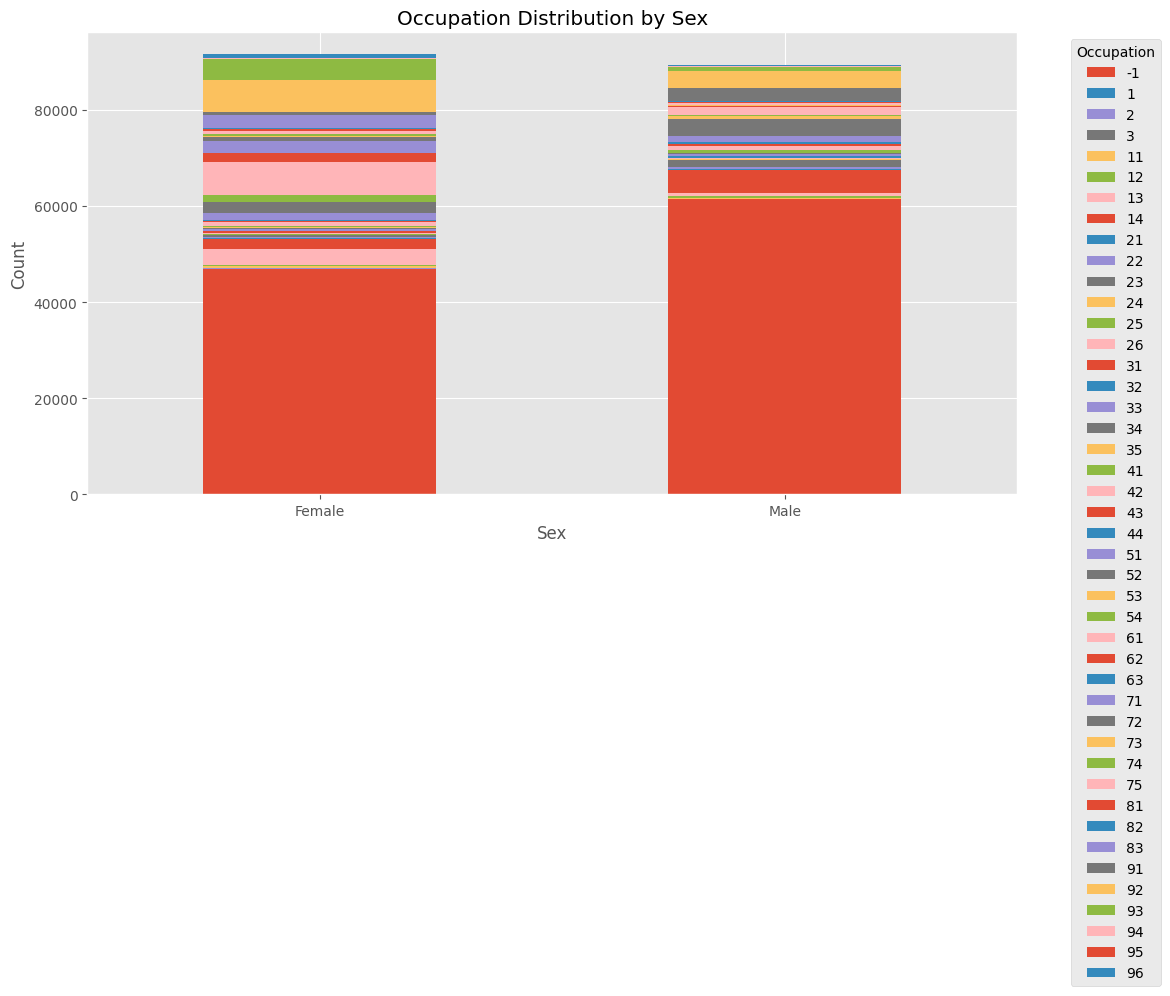

In [37]:
occupation_sex = lfs_data.groupby(['PUFC04_SEX', 'PUFC14_PROCC']).size().unstack(fill_value=0)
occupation_sex.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Occupation Distribution by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks([True, False], ['Male', 'Female'], rotation=0)
plt.legend(title='Occupation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<Figure size 2000x1000 with 0 Axes>

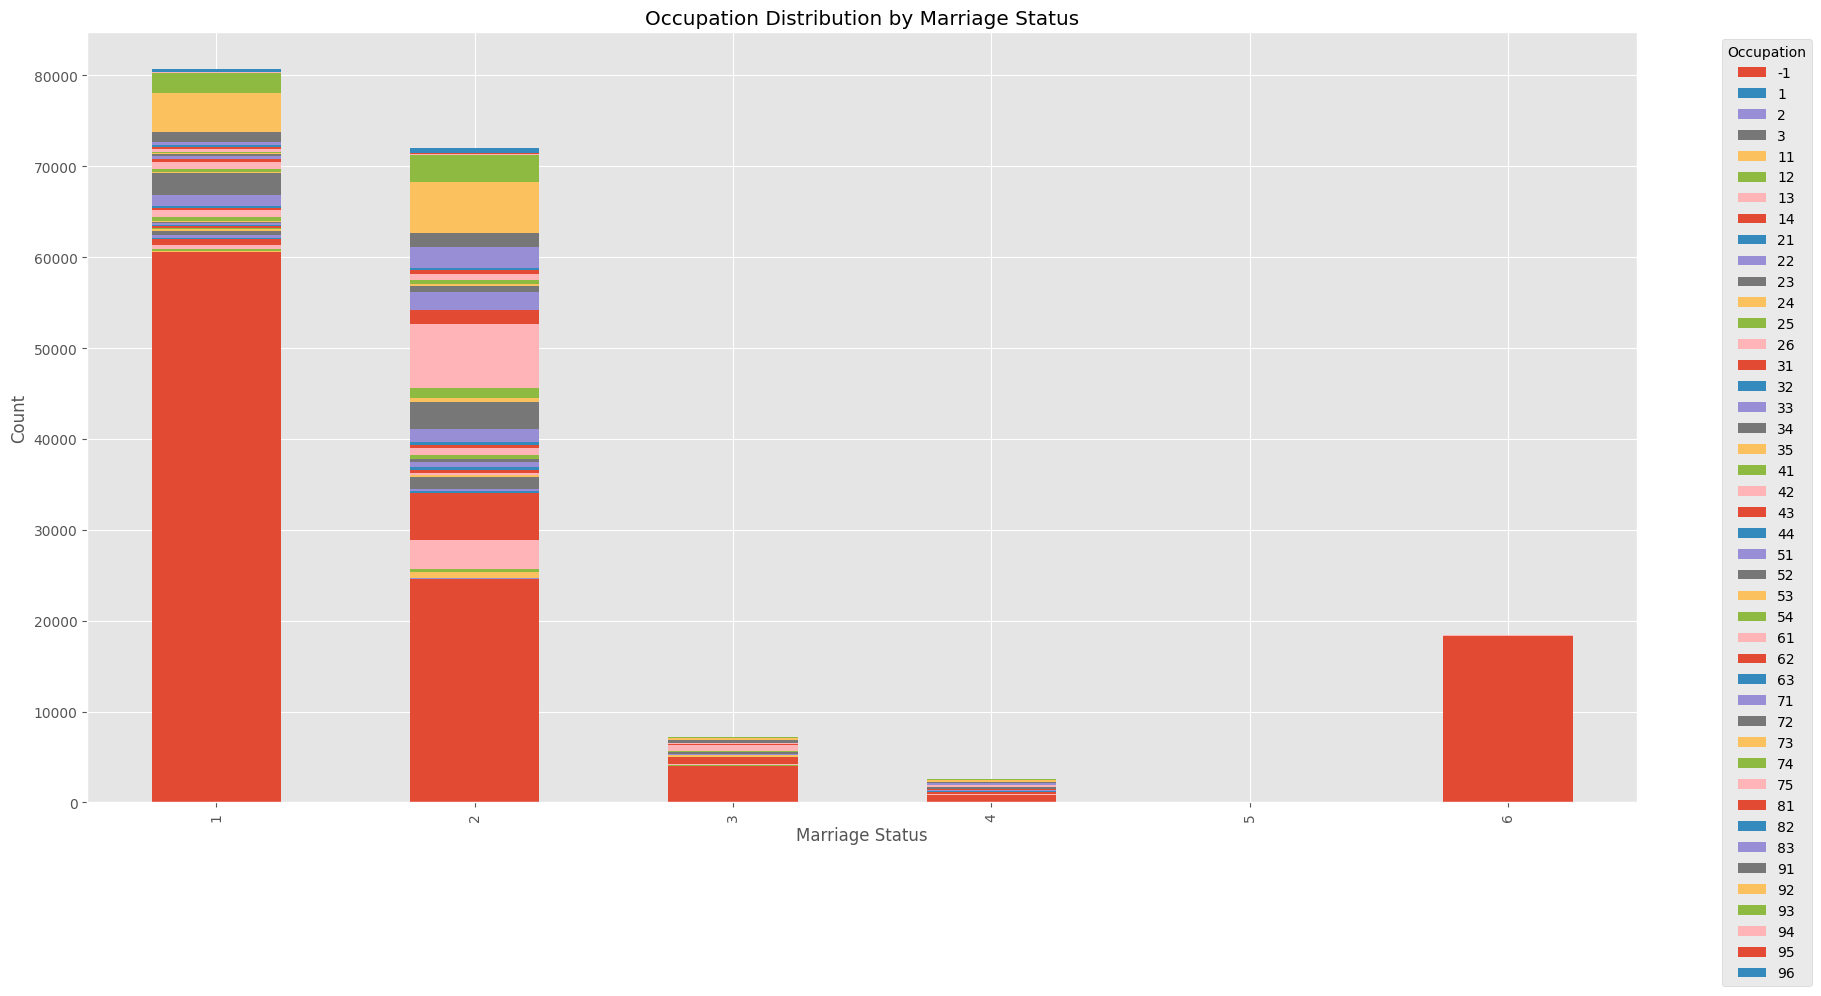

In [38]:
occupation_marriageStatus = lfs_data.groupby(['PUFC06_MSTAT', 'PUFC14_PROCC']).size().unstack(fill_value=0)
plt.figure(figsize=(20, 10))
occupation_marriageStatus.plot(kind='bar', stacked=True, figsize=(20, 10))
plt.title('Occupation Distribution by Marriage Status')
plt.xlabel('Marriage Status')
plt.ylabel('Count')
plt.legend(title='Occupation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<Figure size 2000x1000 with 0 Axes>

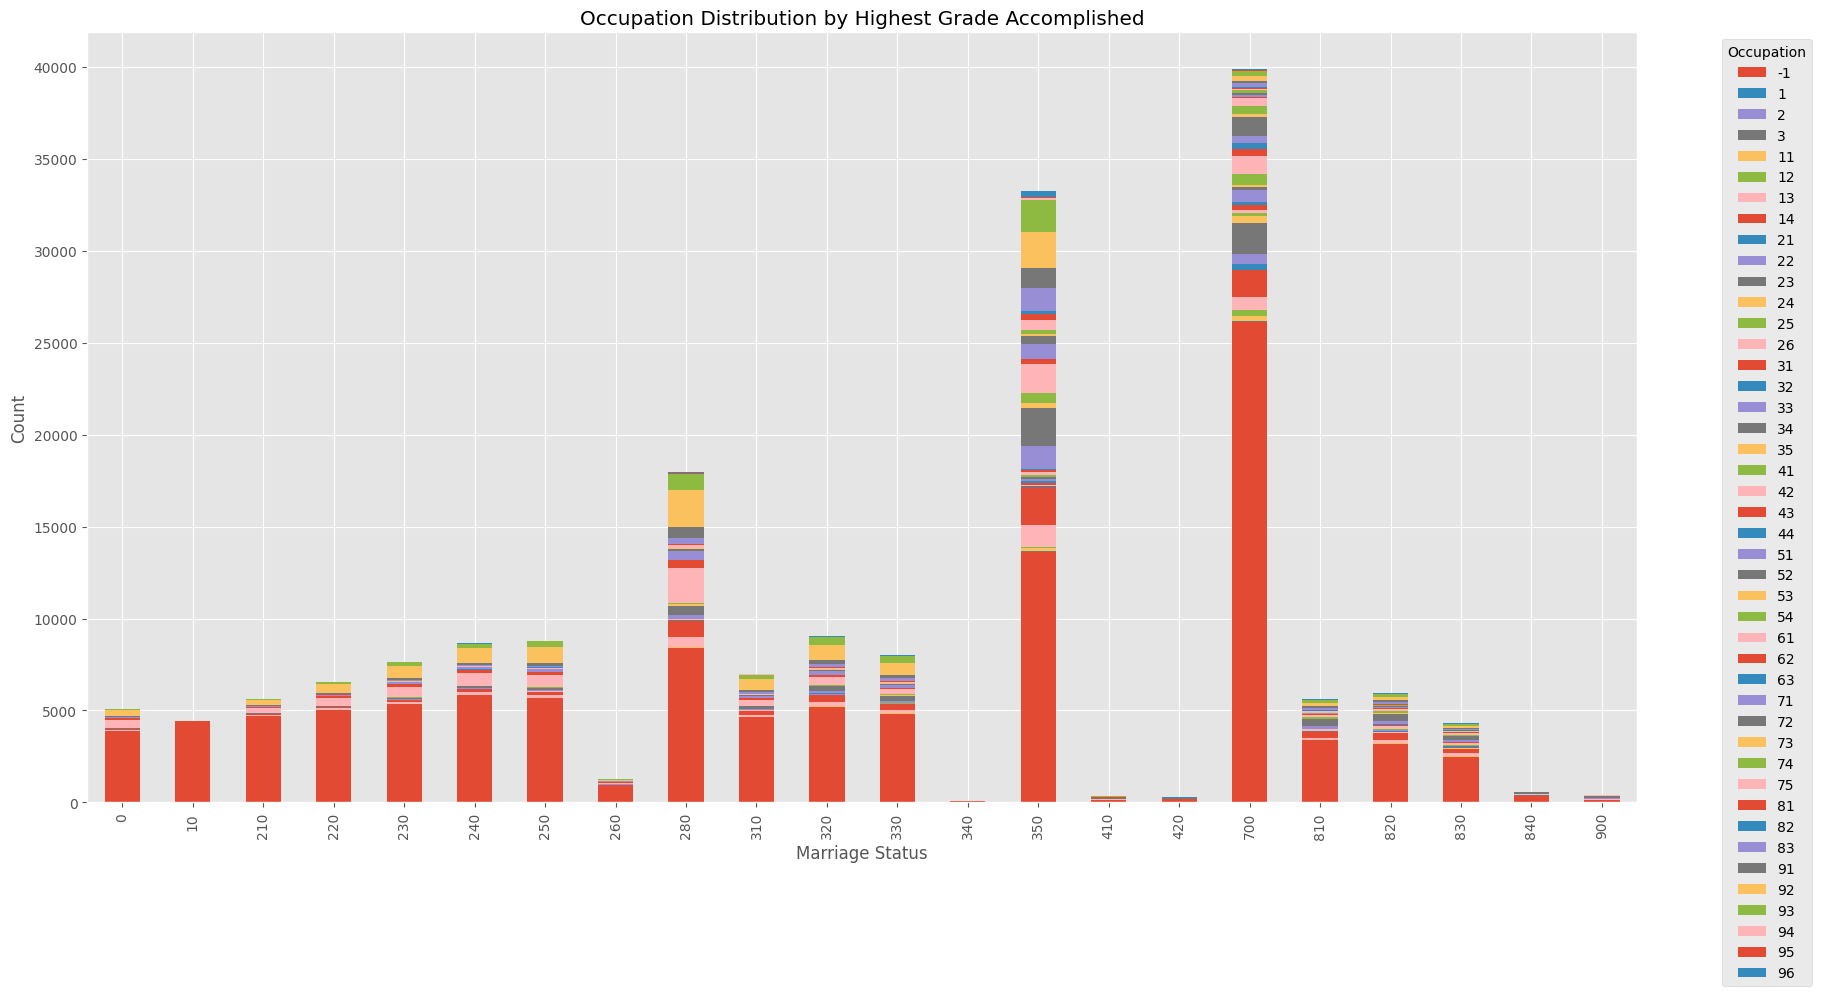

In [39]:
occupation_highestGrade = lfs_data.groupby(['PUFC07_GRADE', 'PUFC14_PROCC']).size().unstack(fill_value=0)
plt.figure(figsize=(20, 10))
occupation_highestGrade.plot(kind='bar', stacked=True, figsize=(20, 10))
plt.title('Occupation Distribution by Highest Grade Accomplished')
plt.xlabel('Marriage Status')
plt.ylabel('Count')
plt.legend(title='Occupation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

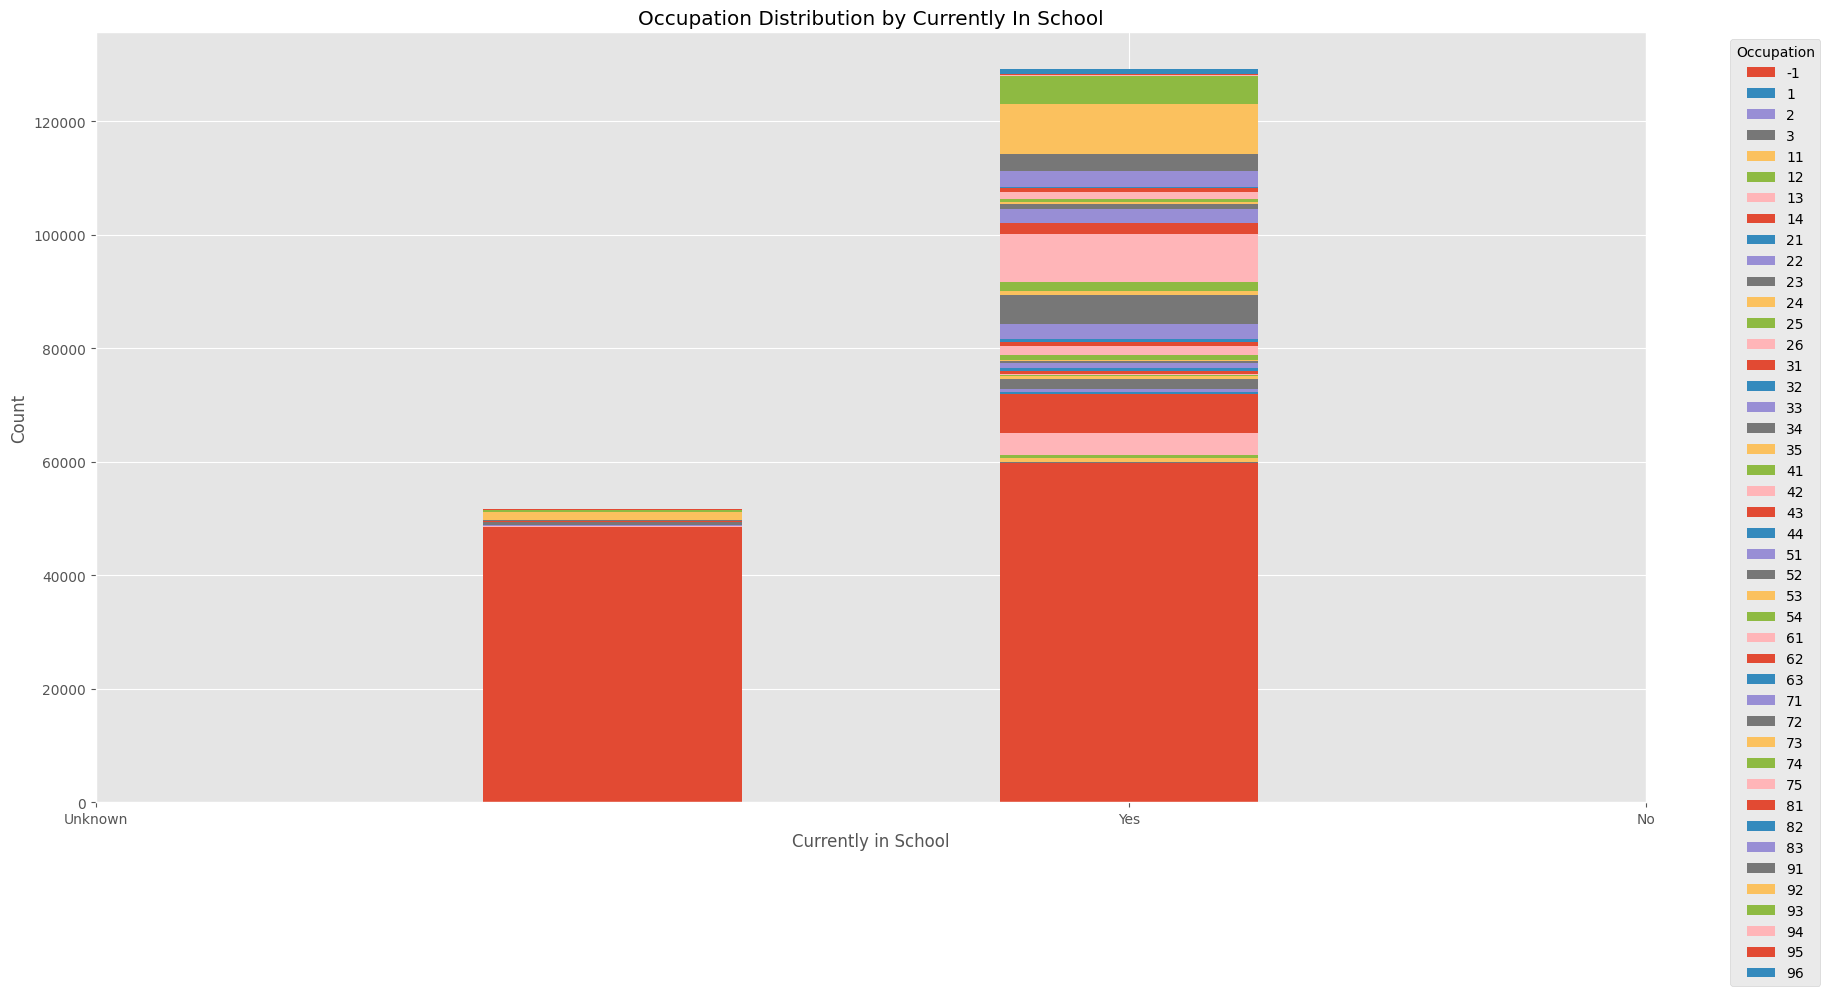

In [40]:
occupation_currently_in_school = lfs_data.groupby(['PUFC08_CURSCH', 'PUFC14_PROCC']).size().unstack(fill_value=0)
occupation_currently_in_school.plot(kind='bar', stacked=True, figsize=(20, 10))
plt.title('Occupation Distribution by Currently In School')
plt.xlabel('Currently in School')
plt.ylabel('Count')
plt.xticks([-1, 1, 2], ['Unknown', 'Yes', 'No'], rotation=0)
plt.legend(title='Occupation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

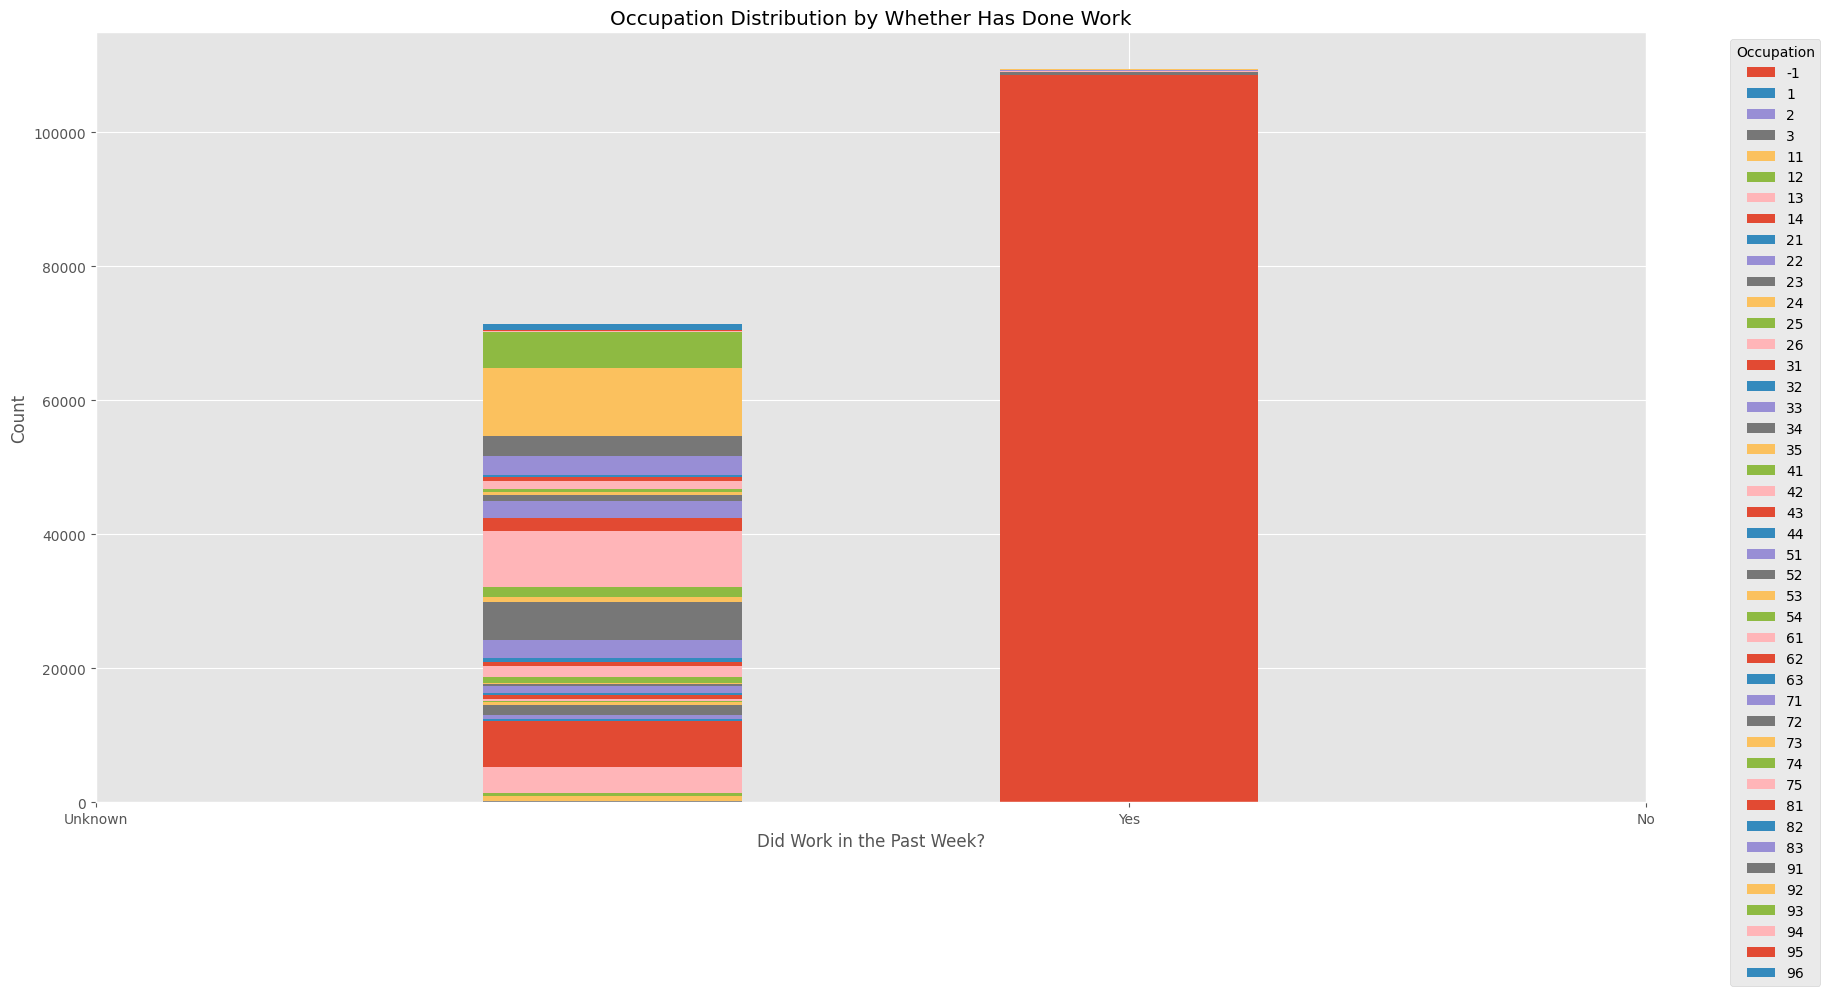

In [41]:
occupation_did_work = lfs_data.groupby(['PUFC11_WORK', 'PUFC14_PROCC']).size().unstack(fill_value=0)
occupation_did_work.plot(kind='bar', stacked=True, figsize=(20, 10))
plt.title('Occupation Distribution by Whether Has Done Work')
plt.xlabel('Did Work in the Past Week?')
plt.ylabel('Count')
plt.xticks([-1, 1, 2], ['Unknown', 'Yes', 'No'], rotation=0)
plt.legend(title='Occupation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

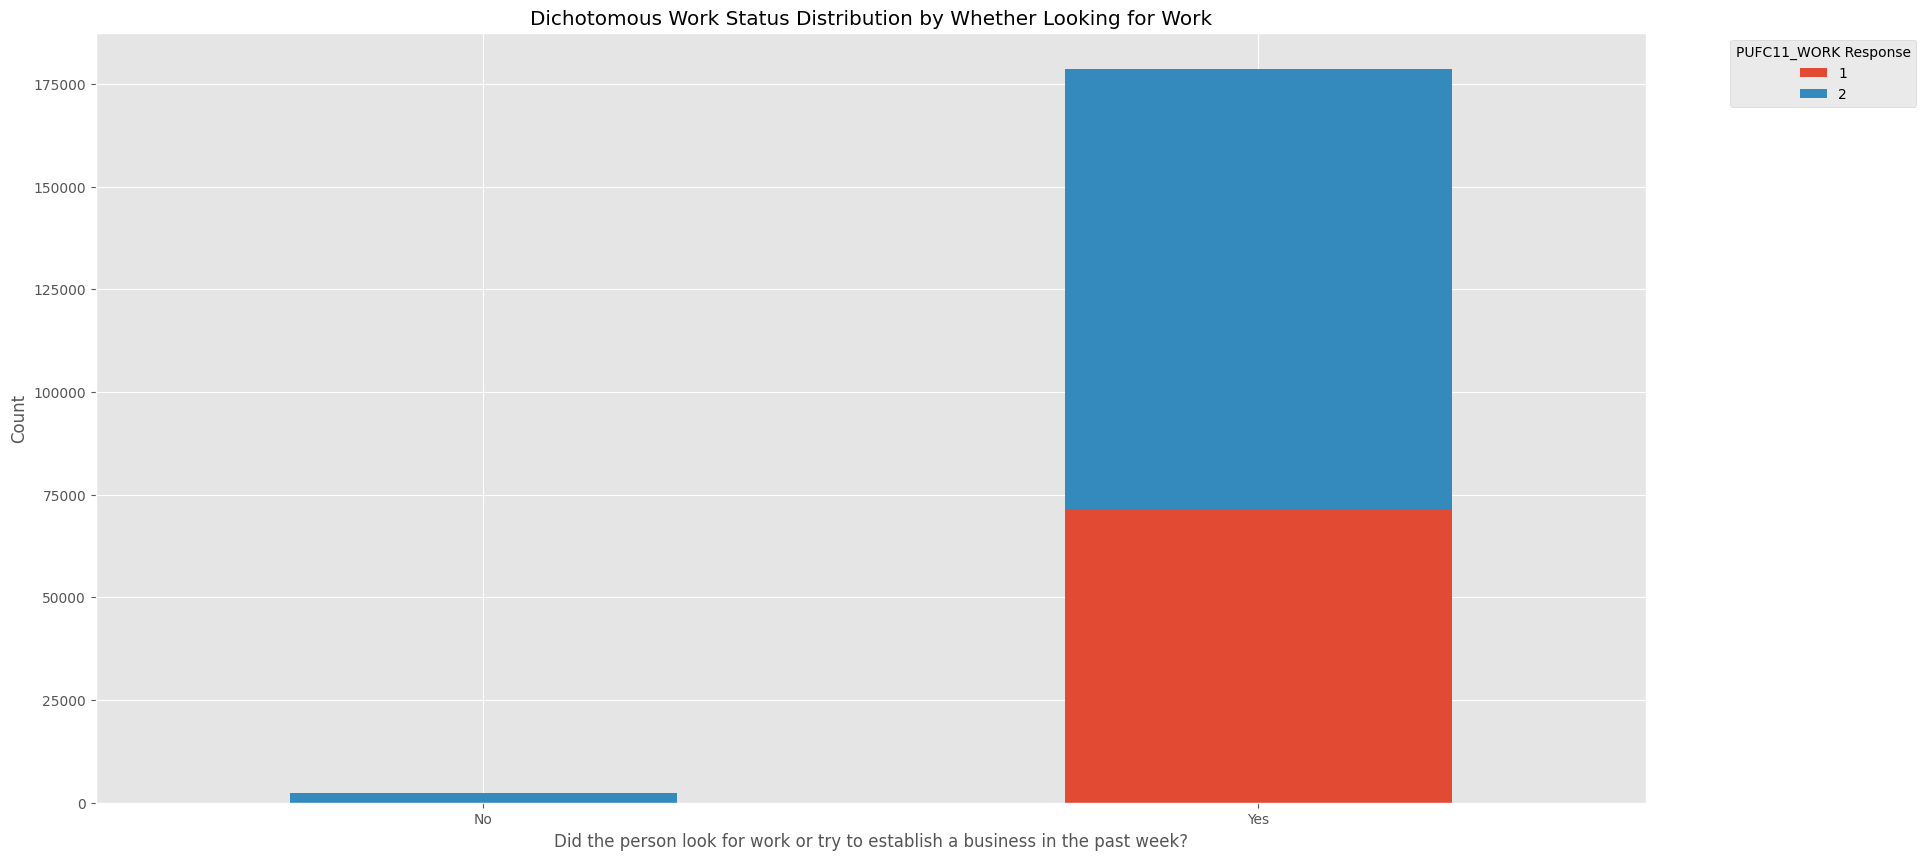

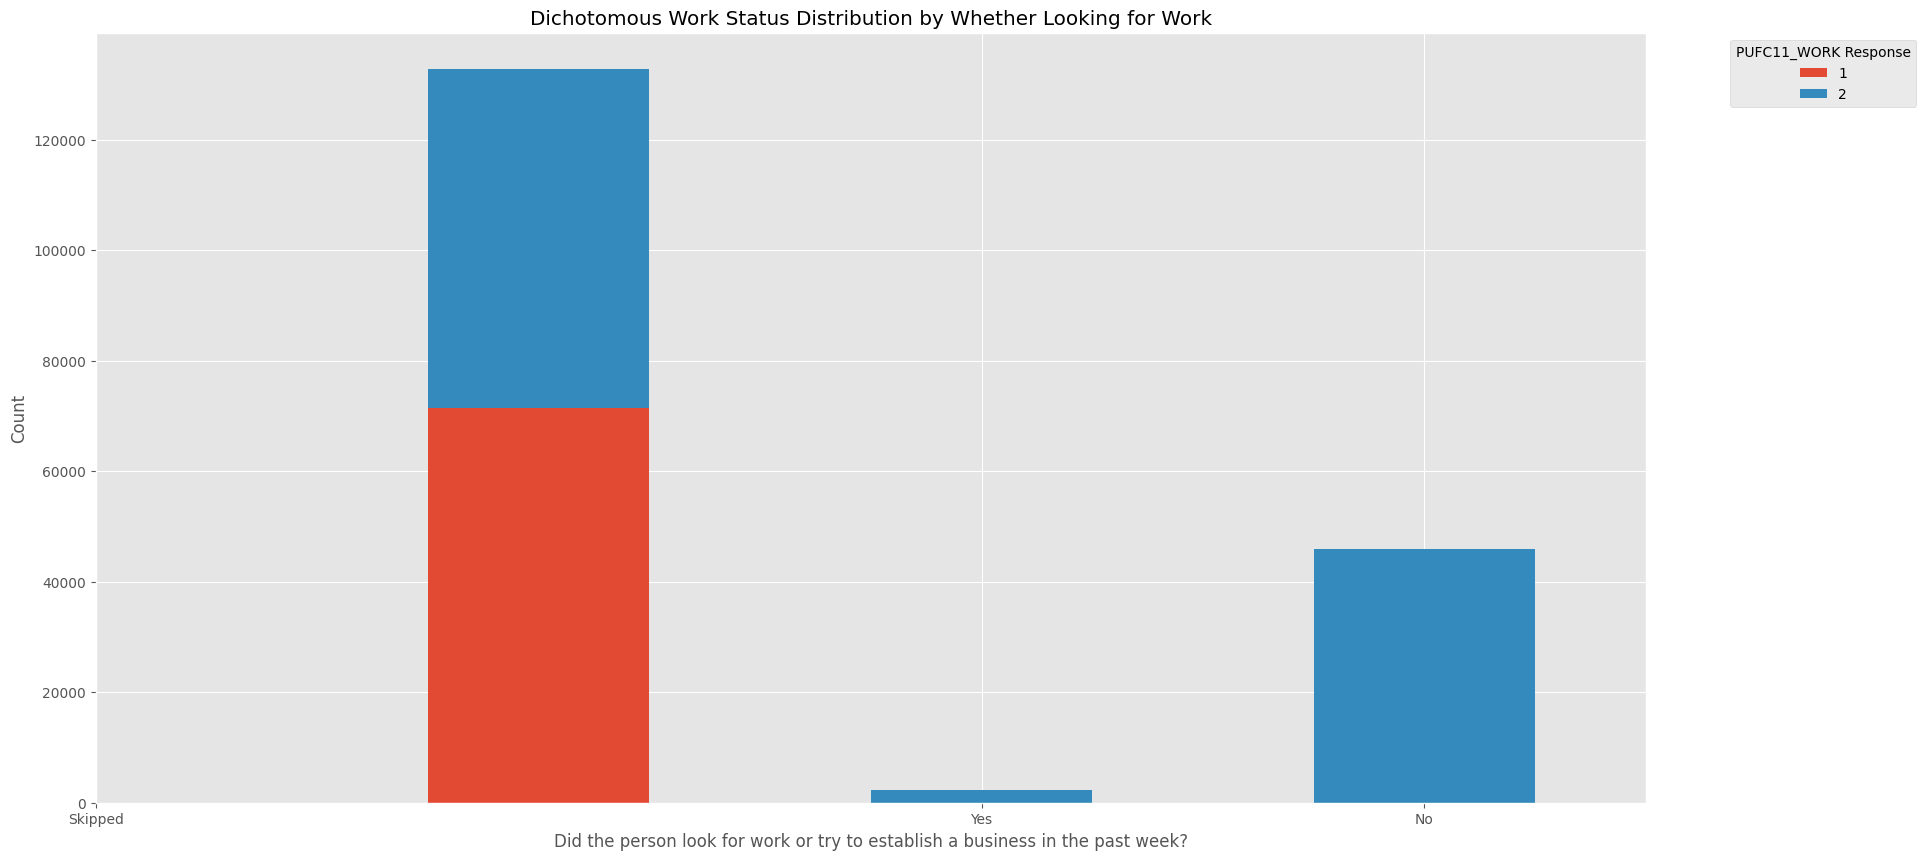

In [42]:
occupation_looking_for_work_ver2 = lfs_data.groupby(['PUFC30_LOOKW_version2', 'PUFC11_WORK']).size().unstack(fill_value=0)
occupation_looking_for_work_ver2.plot(kind='bar', stacked=True, figsize=(20, 10))
plt.title('Dichotomous Work Status Distribution by Whether Looking for Work')
plt.xlabel('Did the person look for work or try to establish a business in the past week?')
plt.ylabel('Count')
plt.xticks([False, True], ['No', 'Yes'], rotation=0)
plt.legend(title='PUFC11_WORK Response', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

occupation_looking_for_work = lfs_data.groupby(['PUFC30_LOOKW', 'PUFC11_WORK']).size().unstack(fill_value=0)
occupation_looking_for_work.plot(kind='bar', stacked=True, figsize=(20, 10))
plt.title('Dichotomous Work Status Distribution by Whether Looking for Work')
plt.xlabel('Did the person look for work or try to establish a business in the past week?')
plt.ylabel('Count')
plt.xticks([-1, 1, 2], ['Skipped', 'Yes', 'No'], rotation=0)
plt.legend(title='PUFC11_WORK Response', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

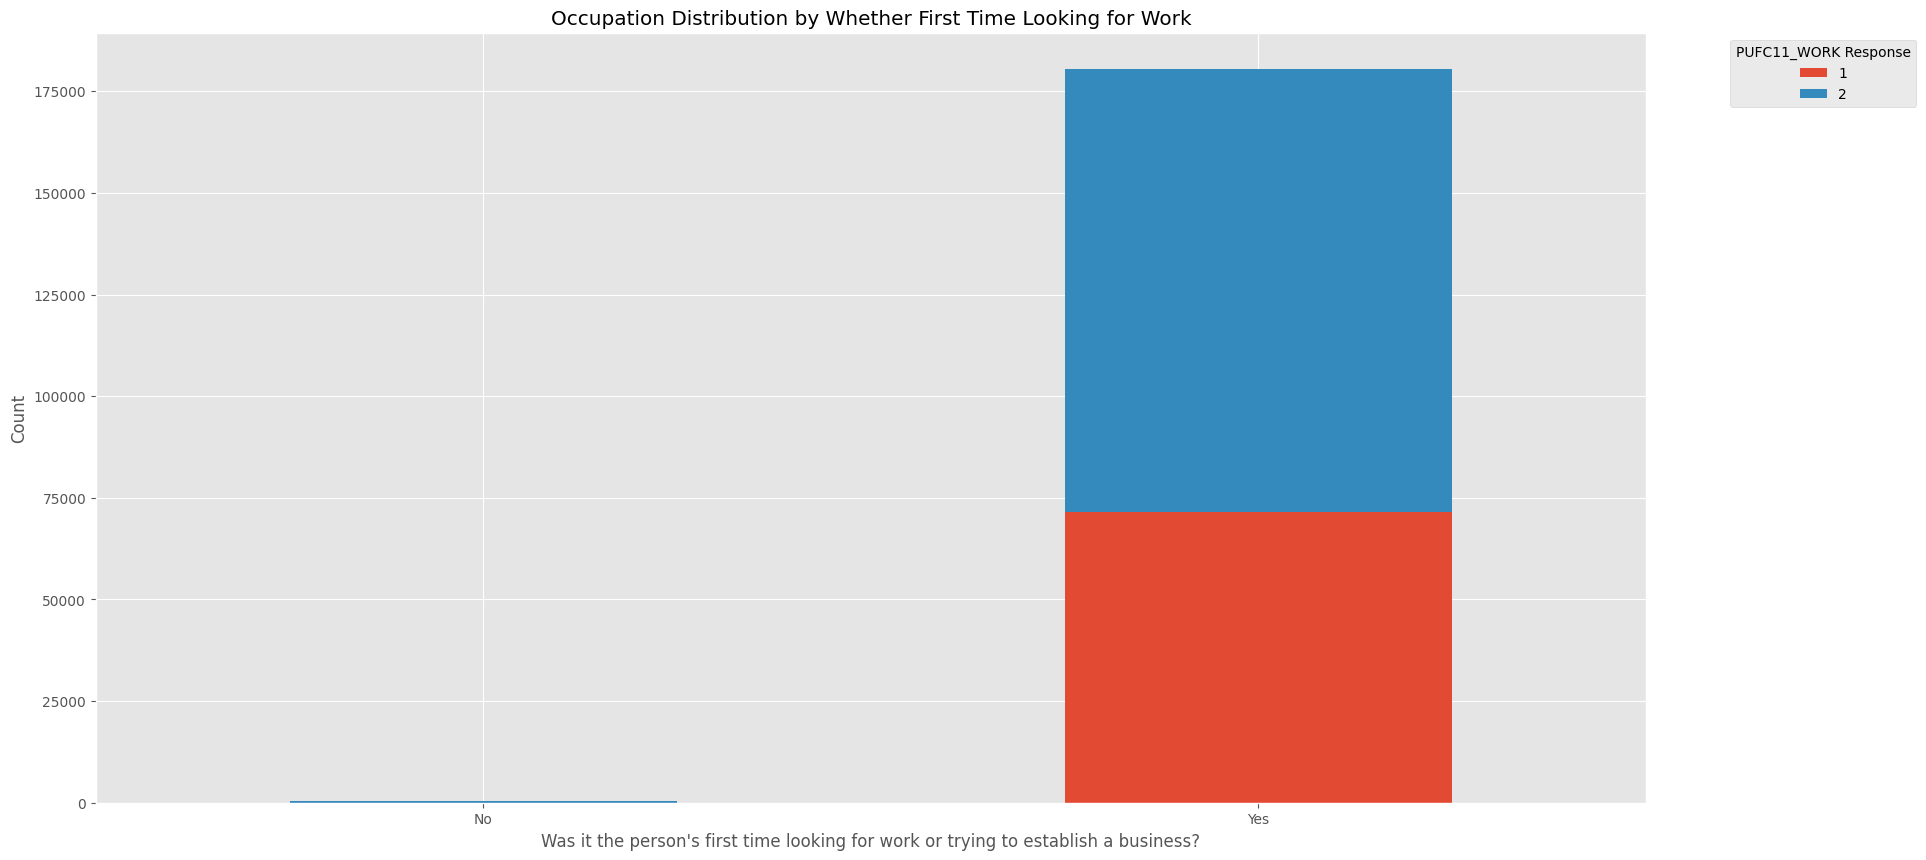

In [43]:
occupation_first_time_looking_for_work_ver2 = lfs_data.groupby(['PUFC31_FLWRK_version2', 'PUFC11_WORK']).size().unstack(fill_value=0)
occupation_first_time_looking_for_work_ver2.plot(kind='bar', stacked=True, figsize=(20, 10))
plt.title('Occupation Distribution by Whether First Time Looking for Work')
plt.xlabel("Was it the person's first time looking for work or trying to establish a business?")
plt.ylabel('Count')
plt.xticks([False, True], ['No', 'Yes'], rotation=0)
plt.legend(title='PUFC11_WORK Response', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# occupation_first_time_looking_for_work = lfs_data.groupby(['PUFC30_LOOKW', 'PUFC11_WORK']).size().unstack(fill_value=0)
# occupation_first_time_looking_for_work.plot(kind='bar', stacked=True, figsize=(20, 10))
# plt.title('Dichotomous Work Status Distribution by Whether First Time Looking for Work')
# plt.xlabel("Was it the person's first time looking for work or trying to establish a business?")
# plt.ylabel('Count')
# plt.xticks([-1, 1, 2], ['Skipped', 'Yes', 'No'], rotation=0)
# plt.legend(title='PUFC11_WORK Response', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

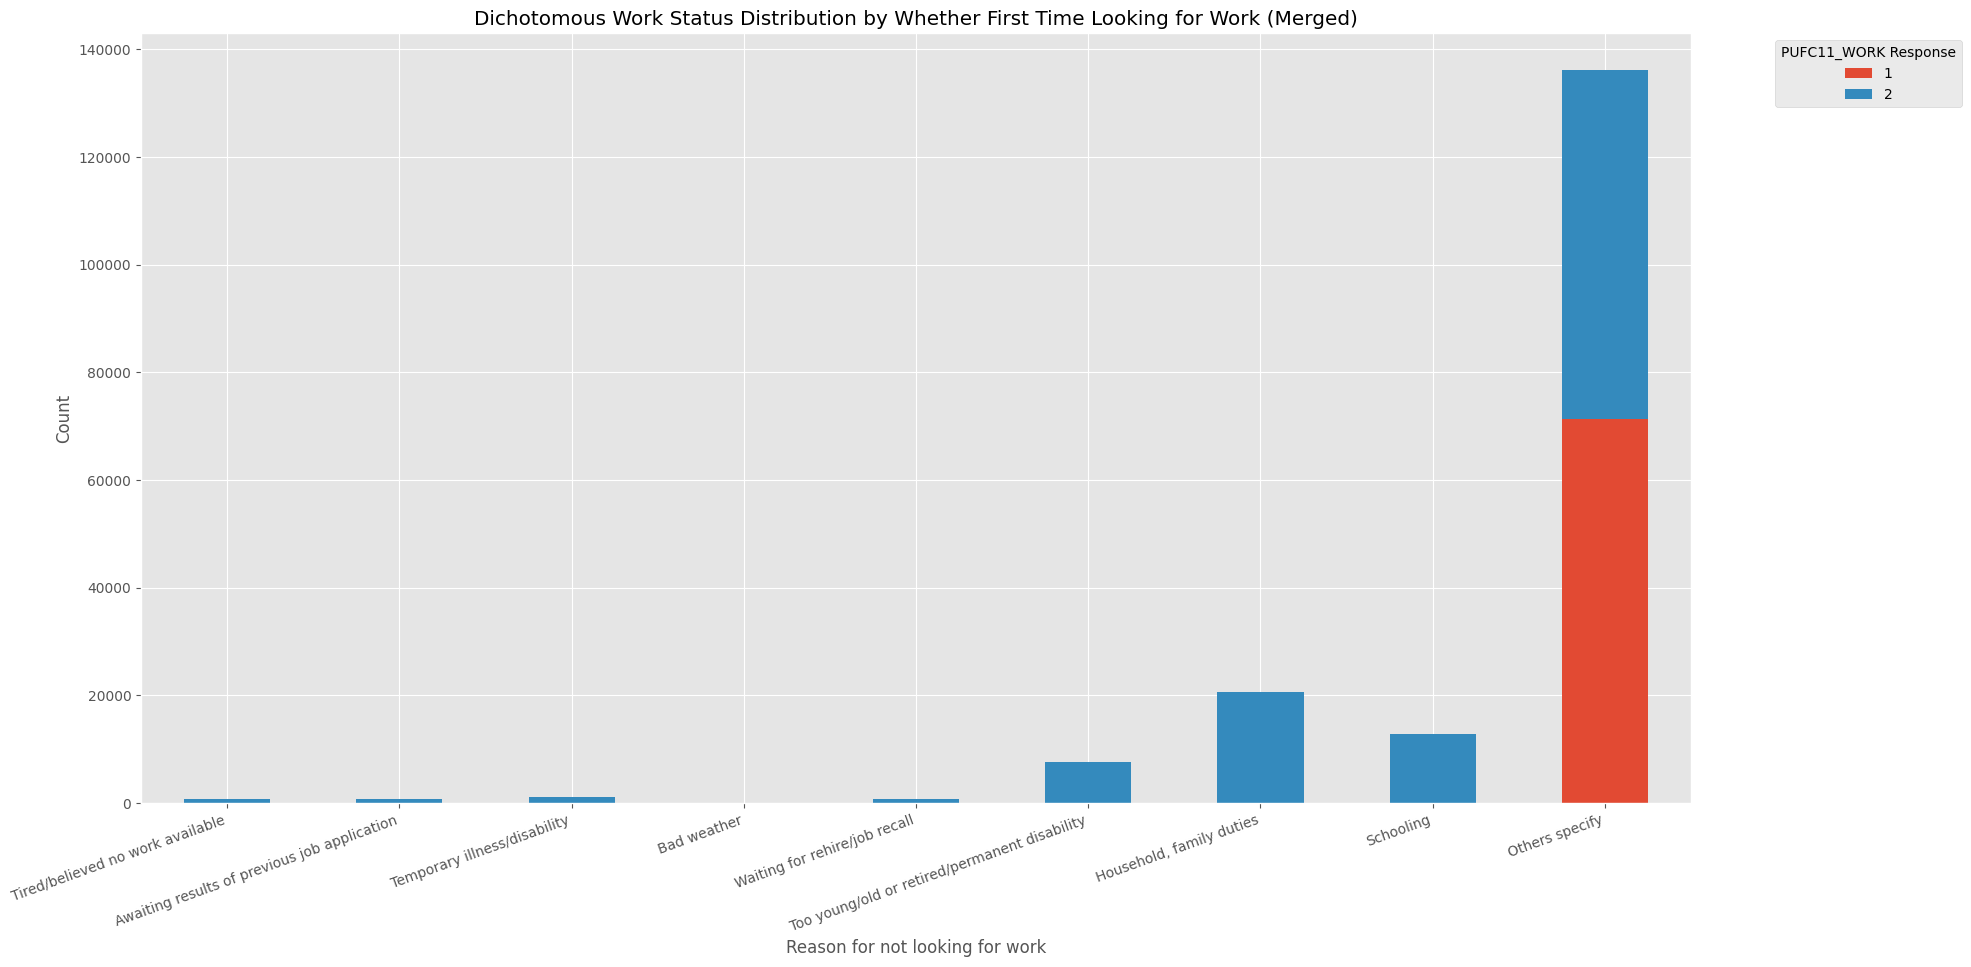

In [44]:
# occupation_reason_not_looking_for_work = lfs_data.groupby(['PUFC34_WYNOT', 'PUFC11_WORK']).size().unstack(fill_value=0)
# occupation_reason_not_looking_for_work.plot(kind='bar', stacked=True, figsize=(20, 10))
# plt.title('Dichotomous Work Status Distribution by Whether First Time Looking for Work')
# plt.xlabel("Reason for not looking for work")
# plt.ylabel('Count')
# plt.legend(title='PUFC11_WORK Response', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

occupation_reason_not_looking_for_work_version3 = lfs_data.groupby(['PUFC34_WYNOT_version3', 'PUFC11_WORK']).size().unstack(fill_value=0)
version_3_histogram = occupation_reason_not_looking_for_work_version3.plot(kind='bar', stacked=True, figsize=(20, 10)).set_xticklabels([
    'Tired/believed no work available', 
    'Awaiting results of previous job application', 
    'Temporary illness/disability', 
    'Bad weather', 
    'Waiting for rehire/job recall', 
    'Too young/old or retired/permanent disability', 
    'Household, family duties', 
    'Schooling', 
    'Others specify'
], rotation=20, ha='right')
plt.title('Dichotomous Work Status Distribution by Whether First Time Looking for Work (Merged)')
plt.xlabel("Reason for not looking for work")
plt.ylabel('Count')
plt.legend(title='PUFC11_WORK Response', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

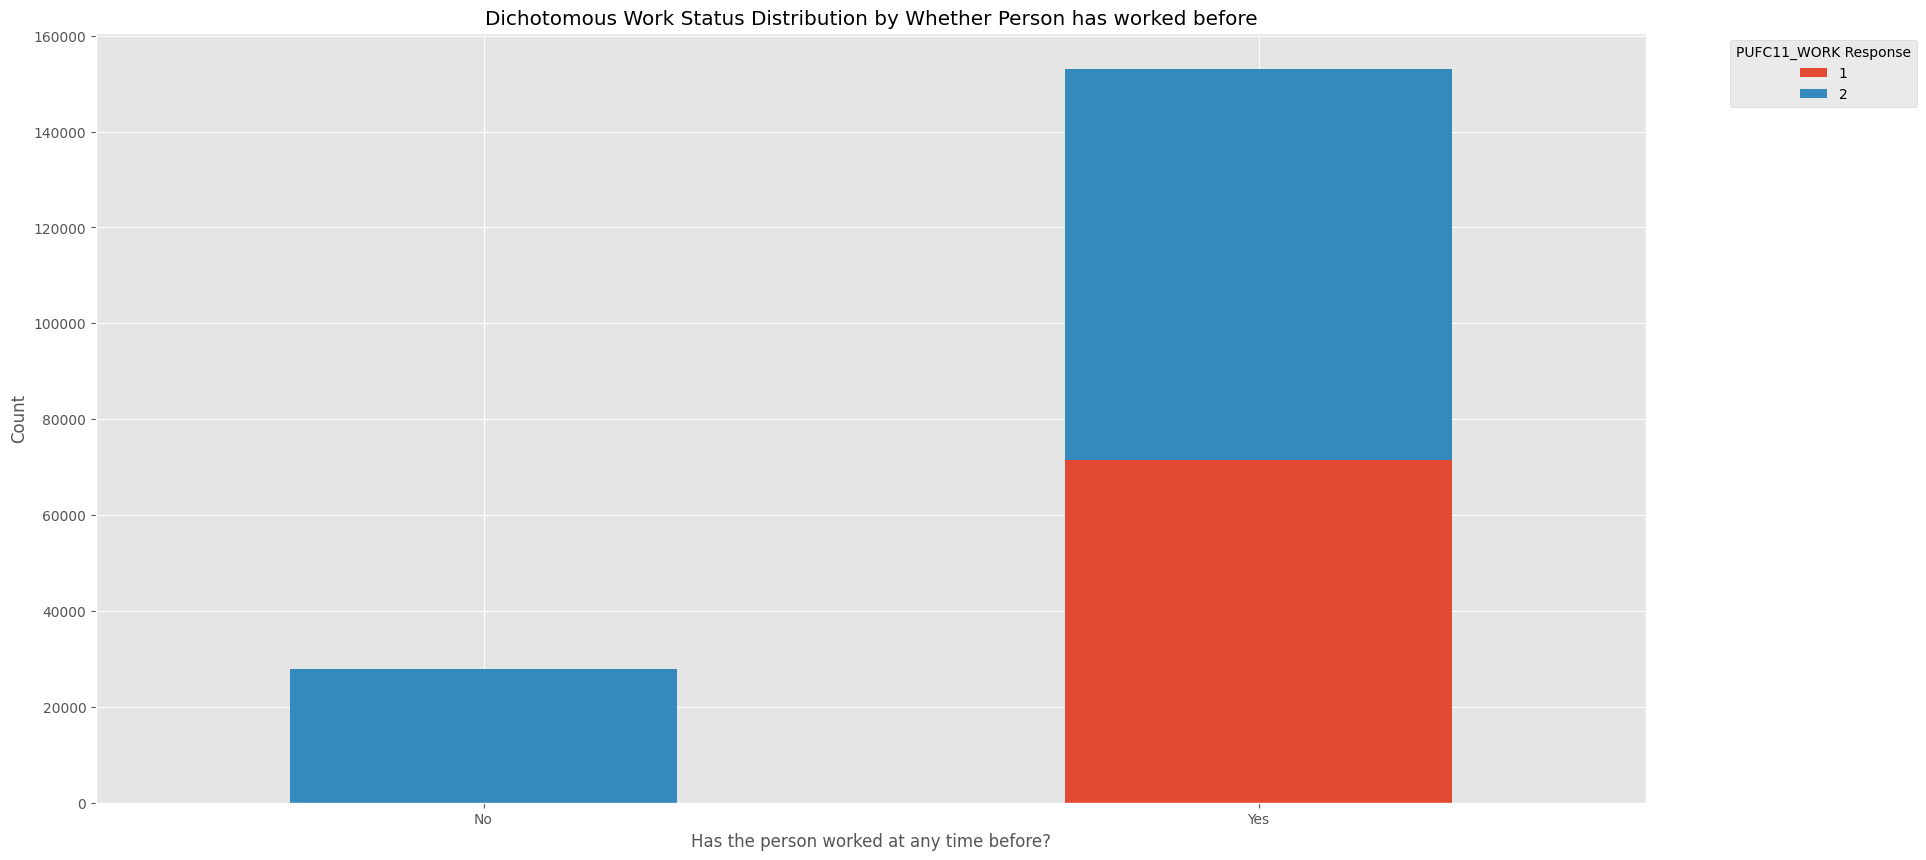

In [45]:
occupation_looking_for_work_ver2 = lfs_data.groupby(['PUFC38_PREVJOB_version2', 'PUFC11_WORK']).size().unstack(fill_value=0)
occupation_looking_for_work_ver2.plot(kind='bar', stacked=True, figsize=(20, 10))
plt.title('Dichotomous Work Status Distribution by Whether Person has worked before')
plt.xlabel('Has the person worked at any time before?')
plt.ylabel('Count')
plt.xticks([False, True], ['No', 'Yes'], rotation=0)
plt.legend(title='PUFC11_WORK Response', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# occupation_looking_for_work = lfs_data.groupby(['PUFC38_PREVJOB', 'PUFC11_WORK']).size().unstack(fill_value=0)
# occupation_looking_for_work.plot(kind='bar', stacked=True, figsize=(20, 10))
# plt.title('Dichotomous Work Status Distribution by Whether Person has worked before')
# plt.xlabel('Has the person worked at any time before?')
# plt.ylabel('Count')
# plt.xticks([-1, 1, 2], ['Skipped', 'Yes', 'No'], rotation=0)
# plt.legend(title='PUFC11_WORK Response', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

---

We will use feature_cols as our predictor variables for PUFC11_WORK. Using Regression, we will evaluate how well we can predict whether or not someone has worked in the past week. We begin with preprocessing.

### Logistic Regression (LR)
Because this is a classification task, we can choose Logistic Regression as a baseline and a first model. In theory, PUFC11_WORK is a binary classification task, something that Logistic Regression should excel at. Since this uses a sigmoid function to map linear probabilities, between 0 and 1, making this suitable for determining whether someone "worked" (1) or "did not work" (0) within the past week. Finally, LR is particularly interpetable considering the task we're doing, allowing us to check the significance and coefficients associated with each predictor variable if need be.

#### Preprocessing: LR
We create a copy of our target variable PUFC11_WORK, and create five 80-20 train-test splits for the non-empty PUFC11 data we have. We'll also perform one-hot encoding, given our feature columns are all categorical. We also map the values of PUFC11, normally [1,2], to [0,1]. In addition, because we've determined that our feature_cols are intentionally unanswered as appropriate, we will be treating these values as empty rather than imputing.

In [53]:
from src.preprocessing import prepare_data

target_col = 'PUFC11_WORK'
feature_cols = [
    'PUFC05_AGE', 'PUFC06_MSTAT', 'PUFC04_SEX', 
    'PUFC07_GRADE', 'PUFC08_CURSCH', 
    'PUFC38_PREVJOB', 'PUFC31_FLWRK',
    'PUFC30_LOOKW', 'PUFC34_WYNOT'
]

categorical_cols = feature_cols
n_splits = 5
missing_value =-1
seed = 45

folds_data = prepare_data(lfs_data, target_col = target_col,
                         missing_value = missing_value,
                         feature_cols = feature_cols,
                         seed = seed)

Preparing data...
Training on 7 samples with 12 features
Features: ['PUFC05_AGE', 'PUFC06_MSTAT', 'PUFC04_SEX', 'PUFC07_GRADE', 'PUFC08_CURSCH', 'PUFC38_PREVJOB', 'PUFC31_FLWRK', 'PUFC30_LOOKW', 'PUFC34_WYNOT']


#### Training: LR
We are ready to start training. As we are setting a baseline, we'll start off with these hyperparameters. We'll use Stochastic Gradient Descent as our specified optimizer, though technically implementing mini-batch with a batch size of 128. We are looking for improvements in loss greater than 0.0001, else we stop early within three epochs. Lastly, we use a weight_decay of 0, indicating no regularization for now. All hyperparameters indicated below also indicate their default value if unspecified. For each convergence, we will track the metrics of that fold and aggregate it across all folds.

In [ ]:
from src.trainEval import *
result_dict = train_model(
    folds_data,
    scheduler_step_size=5,
    learning_rate=0.01,
    scheduler_gamma=0.5,
    convergence_threshold=1e-4, 
    num_epochs=50,
    patience=3, # Stop at 3 epochs with no improvement
    weight_decay=0,
    seed=seed
)

lr_accuracies_test = result_dict["all_final_test_accuracies"]
print(lr_accuracies_test);


print("\nModel training complete!")
aggregate_cm = result_dict["aggregate_confusion_matrix"]

sns.heatmap(aggregate_cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Negative", "Positive"], 
            yticklabels=["Negative", "Positive"]) 


print(f"  Average Final Train Loss:     {result_dict['aggregated_final_metrics']['avg_final_train_loss']:.6f}")
print(f"  Average Final Test Loss:      {result_dict['aggregated_final_metrics']['avg_final_test_loss']:.6f}")
print(f"  Average Final Train Accuracy: {result_dict['aggregated_final_metrics']['avg_final_train_accuracy']:.6f}")
print(f"  Average Final Test Accuracy:  {result_dict['aggregated_final_metrics']['avg_final_test_accuracy']:.6f}")

plt.title("Aggregate Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

TypeError: train_model() got an unexpected keyword argument 'optimizer_string'

#### Error: LR
This model performed well for an initial run. All folds ran for 25 epochs. Both accuracies for test and train data are high, though there is usually minimal improvement from the third epoch onwards. The train and test loss both see steady improvement, but we see the test loss  to be slightly higher and plateau earlier at around the sixteenth epoch. 

We see that the train loss is slightly lower than the test loss in folds 1, 2, and 5, while the reverse is true for folds 3 and 4. This would indicate a model that overfits for the former folds, and underfits for the latter. Averaging these out, its clear that with an aggregated train and test loss of 0.684 and 0.687 respectively, the overall performance of the model doesn't significantly overfit nor underfit. This outcome is surprising, considering that we've used nine predictor variables while also forgoing the use of regularization, as these would have been expected to introduce noise and contribute to overfitting through curse of dimensionality.

In [ ]:
# hyperparameter_results = hyperparameter_random_search(data_dict)
# best_params = hyperparameter_results['best_params']
# results_summary = hyperparameter_results['summary_df']

# final_model = train_model(
#     data_dict, 
#     **best_params
# )

### Hyper Parameter Tuning: LR

With our base parameters having been set, we can begin hyperparameter tuning. We'll implement *Random Search* as to not have to exhaustively branch through each possible combination of parameters. Below are the hyperparameter's we'll use and choose from. For example, if our algorithm randomly, for instance, chooses the second element of each, then it will test Logistic Regression at a learning rate of 0.1, batch size of 64, and the with the ADAM optimizer, etc. 

Values evenly spaced between 0.000001 and 0.001 will be explored for the learning rates. This will go on for fifty iterations, afterwhich a best model will be selected based on test accuracy. We'll perform random search rather than grid search, as a compromise to searching through all 259,200 combinations of hyperparameters in our grid.

In [ ]:
param_distributions = {
    'learning_rate': np.logspace(-4, -1, 20),
    'batch_size': [32, 64, 128, 256],
    'optimizer': ['sgd', 'adam', 'rmsprop'],
    'weight_decay': np.logspace(-5, -2, 10),
    'num_epochs': [30, 50, 75, 100],
    'scheduler_step_size': [5, 10, 15],
    'scheduler_gamma': [0.5, 0.7, 0.9],
    'patience': [3, 5, 7]
}

hyperparameter_results = hyperparameter_random_search(folds_data=folds_data, param_distributions=param_distributions, n_iter_search=50) 

# HPT Interpretation

In [ ]:
# best_params = hyperparameter_results['best_params']
# results_summary = hyperparameter_results['summary_df']

# final_model = train_model(
#     folds_data, 
#     **best_params
# )

## Decision Tree (DT)

Another machine learning model we can use is the decision tree. Decision trees don't necessarily assume a linear relationship between our predictor variables and PUFC11, which could be benificial for finding complex relationships. Rather, they recursively partition our data with rules. Further, while it can get quite complex as it scales, individual nodes are also uncomplicated in how they are interpreted, which is also helpful for understanding the factors that determine whether an individual has worked within the past week.

#### Training: DT
We can recycle the one-hot encoded data we used in preparation for Logistic Regression and immediately use it for training our decision tree.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, log_loss, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import numpy as np

accuracies_train = []
losses_train = []
dt_accuracies_test = []
losses_test = []
confusion_matrices = [] 

for i in range(5):
    X_train, X_test, y_train, y_test = (
        folds_data[i]['X_train'],
        folds_data[i]['X_test'],
        folds_data[i]['y_train'],
        folds_data[i]['y_test'],
    )

    model = DecisionTreeClassifier(random_state=45, min_impurity_decrease=0.001)

    model.fit(X_train, y_train)

    # Train predictions and loss
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    loss_train = log_loss(y_train, y_train_pred_proba)

    # Test predictions and loss
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    loss_test = log_loss(y_test, y_test_pred_proba)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    confusion_matrices.append(cm)

    accuracies_train.append(accuracy_train)
    losses_train.append(loss_train)
    dt_accuracies_test.append(accuracy_test)
    losses_test.append(loss_test)

    print(f"Fold {i+1} - Train Accuracy: {accuracy_train:.4f}, Train Loss: {loss_train:.4f}, Test Accuracy: {accuracy_test:.4f}, Test Loss: {loss_test:.4f}")
    print(f"Fold {i+1} - Confusion Matrix:\n{cm}\n")

avg_accuracy_train = np.mean(accuracies_train)
avg_loss_train = np.mean(losses_train)
avg_accuracy_test = np.mean(dt_accuracies_test)
avg_loss_test = np.mean(losses_test)

print(f"\nAggregated Metrics:")
print(f"Average Train Accuracy: {avg_accuracy_train:.4f}")
print(f"Average Train Loss: {avg_loss_train:.4f}")
print(f"Average Test Accuracy: {avg_accuracy_test:.4f}")
print(f"Average Test Loss: {avg_loss_test:.4f}")

print("\nOverall Confusion Matrix:")
print(sum(confusion_matrices))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

#### Error: DT
Our model is also performing well, and with each confusion metric no less than 0.98. As this is a decision tree, a model usually prone to overfitting, we do see minimal overfitting, seeing as our train loss is higher than our test loss by 0.0023, though this is arguably a negligible gap.



#### Hyperparameter Tuning: DT
Similar to our methodology with Logistic Regression, we will implement random search for our tuning as a compromise to exhaustively searching through each hyperparameter combination. This time, we will explicitly define certain thresholds and measures. 

Our previous two hyperparameters, max_depth and minimum_impurity_decrease, will now range fom 30-60 and 0.001 to 0.1 respectively, adding variability to our parameters despite minimal signs of overfitting. We will allow the min_samples_leaf to enforce generalization or allow leaf nodes with one sample. 

Of note, we will add cost-complexity pruning as a form of regularizaton for our decision trees. We will also be exploring both gini and entropy as criteria, as the former minimizes chances of misclassification while the latter measures information gain.

#### Error: DT
Our model is also performing well, and with each confusion metric no less than 0.98. As this is a decision tree, a model usually prone to overfitting, we do see minimal overfitting, seeing as our train loss is higher than our test loss by 0.0023, though this is arguably a negligible gap.



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, log_loss

p_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [30, 45, 50, 60],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "min_impurity_decrease": [0.001, 0.005, 0.01], ## pre-pruning
    "ccp_alpha": np.logspace(-4, 0, 10) ## post-pruning
}

best_params_list = []
accuracies = []
precisions = []
recalls = []
f1_scores = []
losses = []

for i in range(5):
    X_train, X_test, y_train, y_test = (
        folds_data[i]['X_train'],
        folds_data[i]['X_test'],
        folds_data[i]['y_train'],
        folds_data[i]['y_test'],
    )

    model = DecisionTreeClassifier(random_state=45)

    random_search = RandomizedSearchCV(
        model, p_grid, n_iter=20, cv=5, scoring="accuracy", n_jobs=-1, verbose=1, random_state=45
    )
    random_search.fit(X_train, y_train)

    best_params_list.append(random_search.best_params_)

    accuracies.append(accuracy_score(y_test, random_search.best_estimator_.predict(X_test)))
    report = classification_report(y_test, random_search.best_estimator_.predict(X_test), output_dict=True, zero_division=0)
    losses.append(log_loss(y_test, random_search.best_estimator_.predict_proba(X_test)))
    precisions.append(report['macro avg']['precision'])
    recalls.append(report['macro avg']['recall'])
    f1_scores.append(report['macro avg']['f1-score'])

    print(f"Fold {i+1} - Best Parameters: {random_search.best_params_}")
    print(f"Fold {i+1} - Accuracy: {accuracies[-1]:.4f}, Precision: {precisions[-1]:.4f}, Recall: {recalls[-1]:.4f}, F1-score: {f1_scores[-1]:.4f}, Loss: {losses[-1]:.4f}")


avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)
avg_loss = np.mean(losses)

print(f"\nAggregated Metrics:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-score: {avg_f1:.4f}")
print(f"Average Loss: {avg_loss:.4f}")
print("\nBest Parameters for each fold:")
for i, params in enumerate(best_params_list):
    print(f"Fold {i+1}: {params}")


best_fold_index = np.argmax(accuracies)
best_fold_params = best_params_list[best_fold_index]
print("\nBest Performing Fold Parameters:", best_fold_params)


best_model = DecisionTreeClassifier(random_state=45, **best_fold_params)


all_X_train = np.concatenate([folds_data[i]['X_train'] for i in range(5)])
all_y_train = np.concatenate([folds_data[i]['y_train'] for i in range(5)])

best_model.fit(all_X_train, all_y_train)


In [ ]:
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

train_preds = best_model.predict(X_train)
train_acc = accuracy_score(y_train, train_preds)

test_preds = best_model.predict(X_test)
test_acc = accuracy_score(y_test, test_preds)

train_probs = best_model.predict_proba(X_train)
test_probs = best_model.predict_proba(X_test)
train_loss = log_loss(y_train, train_probs)
test_loss = log_loss(y_test, test_probs)

cm = confusion_matrix(y_test, test_preds)  
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Predicted Negative", "Predicted Positive"], 
            yticklabels=["Actual Negative", "Actual Positive"])


plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")


plt.show()

print(cm)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

print(f"Training Log Loss: {train_loss:.4f}")
print(f"Test Log Loss: {test_loss:.4f}")


train_precision = precision_score(y_train, train_preds, zero_division=0)
test_precision = precision_score(y_test, test_preds, zero_division=0)

train_recall = recall_score(y_train, train_preds, zero_division=0)
test_recall = recall_score(y_test, test_preds, zero_division=0)

train_f1 = f1_score(y_train, train_preds, zero_division=0)
test_f1 = f1_score(y_test, test_preds, zero_division=0)

print(f"Training Precision: {train_precision:.4f}")
print(f"Test Precision: {test_precision:.4f}")

print(f"Training Recall: {train_recall:.4f}")
print(f"Test Recall: {test_recall:.4f}")

print(f"Training F1-score: {train_f1:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

Initial Predictions

In [ ]:
# y_pred = model.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print(f"acc: {accuracy:.4f}")


# print(classification_report(y_test, y_pred))

Hyperparameter Tuning

In [ ]:
# p_grid = {
#     "criterion": ["gini", "entropy"],  
#     "max_depth": [30, 45, 50, 60],  
#     "min_samples_split": [2, 5, 10], 
#     "min_samples_leaf": [1, 2, 4], 
#     "min_impurity_decrease": [0.001, 0.005, 0.01], ## ensures pruning
#     "ccp_alpha": np.logspace(-4, 0, 10)
# }

# random_search = RandomizedSearchCV(model, p_grid, n_iter=20, cv=5, scoring="accuracy", n_jobs=-1, verbose=1, random_state=45)
# random_search.fit(X_train, y_train)

# ## best params 
# print("Best Parameters:", random_search.best_params_)


In [ ]:
# best_model = DecisionTreeClassifier(**random_search.best_params_, random_state=seed)

# best_model.fit(X_train, y_train)


# y_pred = best_model.predict(X_test)

Confirm

In [ ]:
# train_preds = best_model.predict(X_train)
# train_acc = accuracy_score(y_train, train_preds)

# test_preds = best_model.predict(X_test)
# test_acc = accuracy_score(y_test, test_preds)

# train_probs = best_model.predict_proba(X_train)
# test_probs = best_model.predict_proba(X_test)
# train_loss = log_loss(y_train, train_probs)
# test_loss = log_loss(y_test, test_probs)

# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(6, 5))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
#             xticklabels=["Predicted Negative", "Predicted Positive"], 
#             yticklabels=["Actual Negative", "Actual Positive"])

# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")

# plt.show()

# print(cm)

# print(f"Training Accuracy: {train_acc:.4f}")
# print(f"Test Accuracy: {test_acc:.4f}")


# print(f"Training Log Loss: {train_loss:.4f}")
# print(f"Test Log Loss: {test_loss:.4f}")



test different depths & more vals

In [ ]:
# p_grid = {
#     "criterion": ["gini", "entropy", "log_loss"],  
#     "max_depth": [20, 30, 45, 60],  
#     "min_samples_split": [2, 5, 10, 20], 
#     "min_samples_leaf": [1, 2, 4, 6], 
# }

# grid_search = GridSearchCV(estimator=model, param_grid=p_grid, 
#                            cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# grid_search.fit(X_train, y_train)

# print("best params: ", grid_search.best_params_)

# best_model = grid_search.best_estimator_

# y_pred = best_model.predict(X_test)

# train_preds = best_model.predict(X_train)
# train_acc = accuracy_score(y_train, train_preds)

# test_preds = best_model.predict(X_test)
# test_acc = accuracy_score(y_test, test_preds)

# print(f"Training Accuracy: {train_acc:.4f}")
# print(f"Test Accuracy: {test_acc:.4f}")

Check Class Imbalance

In [ ]:
# print("distrib w/ numpy:", np.bincount(y_train))

# ## not too large difference between 1 and 2, thereby with the model already handling it well, no need to change certain characteristics
# ## no need for pruning due to extremely low acc diff on training and test set

In [ ]:
# from sklearn.tree import plot_tree
# import matplotlib.pyplot as plt

# plt.figure(figsize=(20, 10))
# plot_tree(best_model, filled=True, feature_names=X_train.columns, class_names=["Class 0", "Class 1"])
# plt.title("Decision Tree Visualization")
# plt.show()

### kNN

In [ ]:


#initial k value, optimal value will be determined later
k = 5

accuracies_train = []
losses_train = []
knn_accuracies_test = []
losses_test = []
confusion_matrices = [] 

for i, fold in enumerate(folds_data):
    print(f"fold {i+1}")

    X_train = fold['X_train']
    y_train = fold['y_train']
    X_test = fold['X_test']
    y_test = fold['y_test']

    knn_model = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn_model.fit(X_train, y_train)

    y_pred = knn_model.predict(X_test)

    y_train_pred = knn_model.predict(X_train)
    y_train_pred_proba = knn_model.predict_proba(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    loss_train = log_loss(y_train, y_train_pred_proba)

    y_test_pred = knn_model.predict(X_test)
    y_test_pred_proba = knn_model.predict_proba(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    loss_test = log_loss(y_test, y_test_pred_proba)

    cm = confusion_matrix(y_test, y_test_pred)


    accuracies_train.append(accuracy_train)
    losses_train.append(loss_train)
    knn_accuracies_test.append(accuracy_test)
    losses_test.append(loss_test)

    ## perf metrics
    print(f"Fold {i+1} - Train Accuracy: {accuracy_train:.4f}, Train Loss: {loss_train:.4f}, Test Accuracy: {accuracy_test:.4f}, Test Loss: {loss_test:.4f}")
    print(f"Fold {i+1} - Confusion Matrix:\n{cm}\n")



Find Optimal K value (hpt)

In [ ]:
# k_values = range(1, 21)

# crossvalscores = []

# for k in k_values:
#     knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
#     scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy') 
#     crossvalscores.append(scores.mean())

# best_k = k_values[np.argmax(crossvalscores)]

# print("best k:", best_k)


In [ ]:


param_grid = {'n_neighbors': range(1, 31)} 

grid_search = GridSearchCV(KNeighborsClassifier(weights='distance'), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("best k:", grid_search.best_params_['n_neighbors'])

In [ ]:
knn_cm = confusion_matrix(y_test, y_pred)
print(knn_cm)
knn_acc = accuracy_score(y_test, y_pred)
print("acc: ", knn_acc)

### Statistical Testing

In [ ]:
print(" LR Accuracies:", lr_accuracies_test)
print(" DT Accuracies:", dt_accuracies_test)
print(" KNN Accuracies:", knn_accuracies_test)

dt_accuracies_test = np.array(dt_accuracies_test)
knn_accuracies_test = np.array(knn_accuracies_test) 
rf_accuracies_test = np.array(lr_accuracies_test) 